# Importaciones

In [1]:
!pip install -q evaluate transformers datasets seaborn nltk spacy torch chardet umap umap-learn wordcloud scikit-learn sentence_transformers transformers[torch] sentencepiece
!python3 -m spacy download en_core_web_sm

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Apps > Advanced app settings > App execution aliases.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import nltk, re, spacy
import torch, os, zipfile, chardet, umap

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk import pos_tag
from evaluate import load
from torch.utils.data import Dataset
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import jensenshannon
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

c:\Users\juanm\Desktop\Workspace\ia\NLP-News-Classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando: cuda


# Dataset cargado limpiado

In [3]:
def unzip_data(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)


unzip_data("data/bbc-train.zip", "data")
unzip_data("data/bbc-test.zip", "data")

In [4]:
# Cargar datos desde carpetas
def load_data(data_path):
    categories = ["business", "entertainment", "politics", "sports", "tech"]
    data = []

    def detect_encoding(file_path):
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read())
        return result['encoding']

    for category in categories:
        folder_path = os.path.join(data_path, category)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            encoding = detect_encoding(file_path)
            with open(file_path, "r", encoding=encoding, errors="replace") as f:
                text = f.read()
                data.append((text, category))

    return pd.DataFrame(data, columns=["text", "category"])

# Cargar conjuntos de entrenamiento y test
df_train = load_data("data/bbc-train/")
df_test = load_data("data/bbc-test/")

# Preprocesamiento (Pipeline)

In [5]:
# Descargar recursos necesarios
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Cargar modelo de spaCy para lematización
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 4e6

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
example = df_train["text"].iloc[0]

## 1. Tokenización

In [7]:
# 1. Tokenización
tokens = word_tokenize(example.lower())  # Convertir a minúsculas y tokenizar
tokens[:9]

['ad',
 'sales',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterly',
 'profits',
 'at']

## 2. Estandarización

In [8]:
def standardize_tokens_spacy(tokens):
    text = " ".join(tokens)
    doc = nlp(text)

    standardized_tokens = [
        unicodedata.normalize("NFKD", token.text).encode("ASCII", "ignore").decode("utf-8")  # Eliminar acentos
        for token in doc
        if token.is_alpha
    ]

    return standardized_tokens

In [9]:
std_tokens = standardize_tokens_spacy(tokens)
print(std_tokens[:9])
print(f"Num tokens sin std: {len(tokens)}\nNum tokens con std: {len(std_tokens)}")

['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at']
Num tokens sin std: 490
Num tokens con std: 412


## 3. Stop-words

In [10]:
stop_words = set(stopwords.words("english"))
stop_tokens = [token for token in std_tokens if token not in stop_words]
print(stop_tokens[:9])
print(f"Num tokens sin stop-words: {len(std_tokens)}\nNum tokens con stop-words: {len(stop_tokens)}")

['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'us']
Num tokens sin stop-words: 412
Num tokens con stop-words: 242


## 4. Stemming

In [11]:
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(token) for token in stop_tokens]
stemmed_tokens[:9]

['ad',
 'sale',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterli',
 'profit',
 'us']

## 5. Lematización

In [12]:
lemmatized_tokens = [token.lemma_ for token in nlp(" ".join(stemmed_tokens))]
lemmatized_tokens[:9]

['ad',
 'sale',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterli',
 'profit',
 'we']

## 6. Desambiguación

In [13]:
def get_wordnet_pos(word):
    """Mapea las etiquetas de POS de NLTK a las de WordNet."""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
disambiguated_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in lemmatized_tokens]
disambiguated_tokens[:9]

['ad',
 'sale',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterli',
 'profit',
 'we']

## 7. Pipeline final

In [14]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = standardize_tokens_spacy(tokens)
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return tokens

In [15]:
df_train["processed"] = df_train["text"].apply(preprocess_text)
df_test["processed"] = df_test["text"].apply(preprocess_text)

In [16]:
print(df_train["processed"].iloc[0][:9])
df_train.head()

['ad', 'sale', 'boost', 'time', 'warner', 'profit', 'quarterli', 'profit', 'we']


text  category  \
0  Ad sales boost Time Warner profit\n\nQuarterly...  business   
1  Dollar gains on Greenspan speech\n\nThe dollar...  business   
2  Yukos unit buyer faces loan claim\n\nThe owner...  business   
3  High fuel prices hit BA's profits\n\nBritish A...  business   
4  Pernod takeover talk lifts Domecq\n\nShares in...  business   

                                           processed  
0  [ad, sale, boost, time, warner, profit, quarte...  
1  [dollar, gain, greenspan, speech, dollar, hit,...  
2  [yuko, unit, buyer, face, loan, claim, owner, ...  
3  [high, fuel, price, hit, ba, profit, british, ...  
4  [pernod, takeov, talk, lift, domecq, share, uk...

In [17]:
print(df_test["processed"].iloc[0][:9])
df_test.head()

['u', 'trade', 'gap', 'hit', 'record', 'gap', 'we', 'export', 'import']


text  category  \
0  US trade gap hits record in 2004\n\nThe gap be...  business   
1  Yukos loses US bankruptcy battle\n\nA judge ha...  business   
2  Safety alert as GM recalls cars\n\nThe world's...  business   
3  Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...  business   
4  Strong demand triggers oil rally\n\nCrude oil ...  business   

                                           processed  
0  [u, trade, gap, hit, record, gap, we, export, ...  
1  [yuko, lose, we, bankruptci, battl, judg, dism...  
2  [safeti, alert, gm, recal, car, world, big, ca...  
3  [steel, firm, cut, job, mittal, steel, one, wo...  
4  [strong, demand, trigger, oil, ralli, crude, o...

## 8. N-gramas

In [18]:
bigrams = list(ngrams(disambiguated_tokens, 2))
trigrams = list(ngrams(disambiguated_tokens, 3))

bigrams_str = [" ".join(grama) for grama in bigrams]
trigrams_str = [" ".join(grama) for grama in trigrams]

print(bigrams_str[:5])
print(trigrams_str[:5])

['ad sale', 'sale boost', 'boost time', 'time warner', 'warner profit']
['ad sale boost', 'sale boost time', 'boost time warner', 'time warner profit', 'warner profit quarterli']


# Análisis de los conjuntos de datos

## Distribución de clases

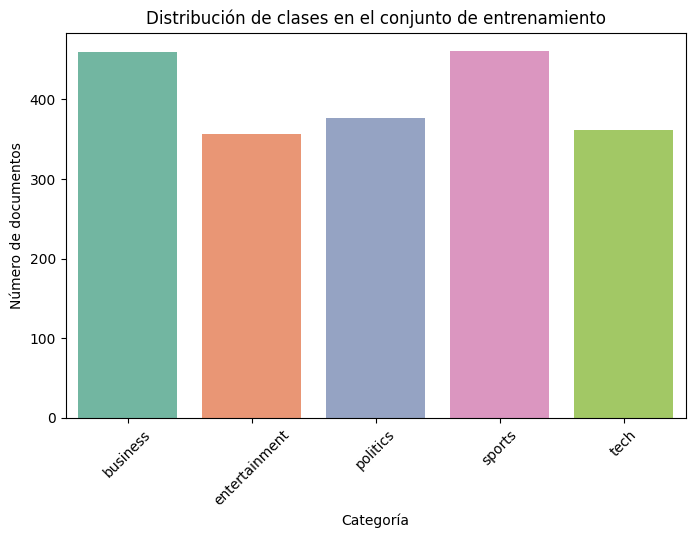

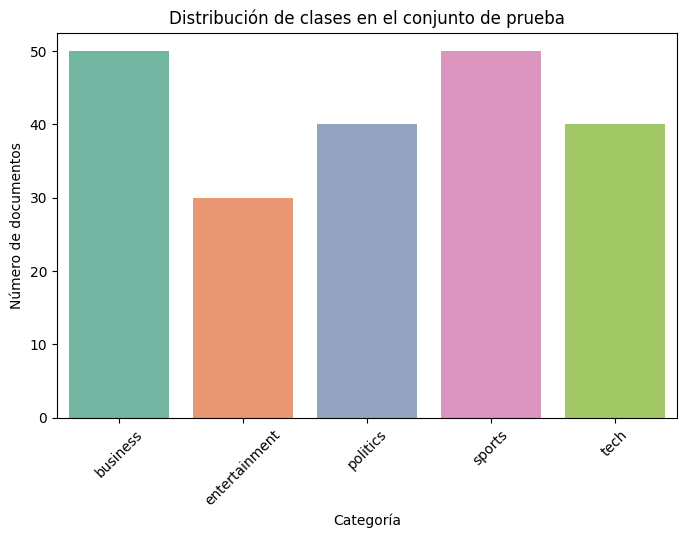

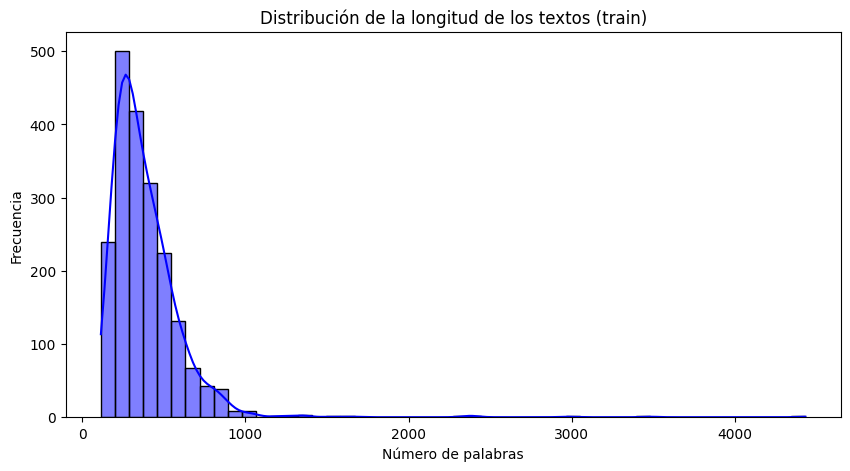

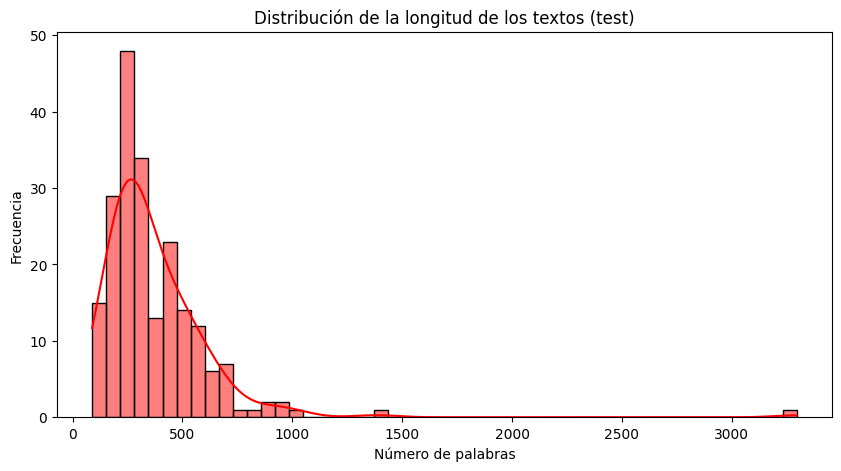

In [19]:
# Distribución de clases en el conjunto de entrenamiento
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_train, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Distribución de clases en el conjunto de prueba
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_test, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de prueba")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Estadísticas básicas sobre la longitud de los textos
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))
df_test["text_length"] = df_test["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(df_train["text_length"], bins=50, kde=True, color="blue")
plt.title("Distribución de la longitud de los textos (train)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_test["text_length"], bins=50, kde=True, color="red")
plt.title("Distribución de la longitud de los textos (test)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

## TD-IDF

In [20]:
vectorizer = TfidfVectorizer(max_features=5000)

df_train["processed_text"] = df_train["processed"].apply(lambda tokens: " ".join(tokens))
df_test["processed_text"] = df_test["processed"].apply(lambda tokens: " ".join(tokens))

X_train_tfidf = vectorizer.fit_transform(df_train["processed_text"])
X_test_tfidf = vectorizer.transform(df_test["processed_text"])

# Visualización de algunas palabras más relevantes por clase
feature_names = vectorizer.get_feature_names_out()
category_keywords = {}

for category in df_train["category"].unique():
    idx = df_train[df_train["category"] == category].index
    mean_tfidf = X_train_tfidf[idx].mean(axis=0)
    sorted_indices = mean_tfidf.argsort()[0, -10:].tolist()[0]
    category_keywords[category] = [feature_names[i] for i in sorted_indices]

keywords = {f"{category}": [] for category, _ in category_keywords.items()}
for category, words in category_keywords.items():
    keywords[category] = words

pd.DataFrame(keywords).T

0      1        2       3      4          5      6  \
business         rise  price  economi  growth   year     market   firm   
entertainment   oscar   year     band    good    say       show  music   
politics       minist  would    torus  govern  blair      parti  elect   
sports            cup   club     team   match    say     player    win   
tech           servic   user   comput   phone  peopl  technolog  mobil   

                     7      8     9  
business       compani   bank   say  
entertainment     star  award  film  
politics        labour    say    mr  
sports         england   play  game  
tech               say    use  game

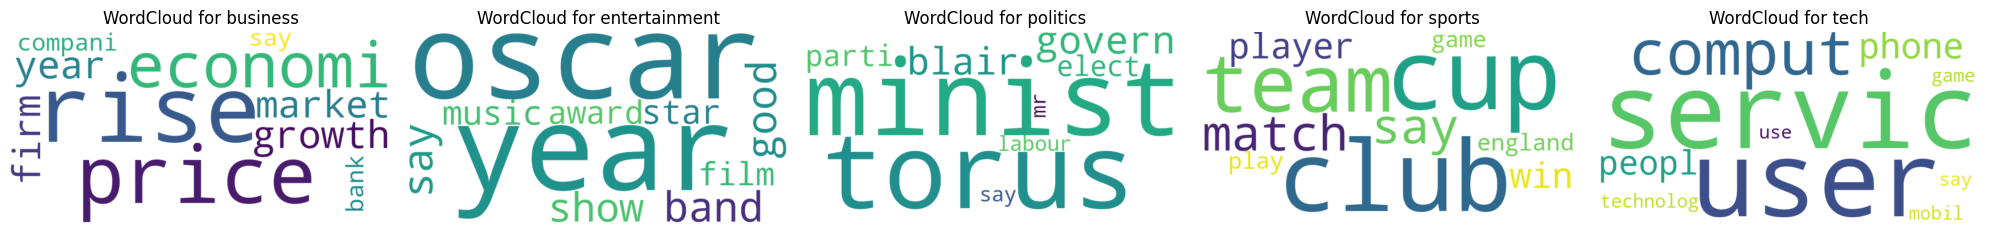

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for idx, (category, words) in enumerate(category_keywords.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))

    ax = axes[idx]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"WordCloud for {category}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [22]:
# --- Preparación de datos supervisados ---

# Mapeo explícito de etiquetas usando un diccionario
label_dict = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sports': 3,
    'tech': 4
}

# Agregar una columna numérica 'label' en los DataFrames
df_train["label"] = df_train["category"].map(label_dict)
df_test["label"] = df_test["category"].map(label_dict)

# Dividir df_train en entrenamiento y validación
from sklearn.model_selection import train_test_split

texts_train, texts_val, labels_train, labels_val = train_test_split(
    df_train["processed_text"].tolist(),
    df_train["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_train["label"]
)

# Preparar el conjunto de test (se mantiene igual)
texts_test = df_test["processed_text"].tolist()
labels_test = df_test["label"].tolist()

print("Ejemplos de entrenamiento:", len(texts_train))
print("Ejemplos de validación:", len(texts_val))
print("Ejemplos de test:", len(texts_test))


Ejemplos de entrenamiento: 1612
Ejemplos de validación: 403
Ejemplos de test: 210


## Word Embeddings Word2Vec

In [23]:
sentences = df_train["processed"].apply(lambda x: ' '.join(x)).tolist()
doc = nlp(" ".join(sentences))  # Procesar todo el texto

# Ver los vectores de las palabras
word_vectors = {}
for token in doc:
    if not token.is_stop and not token.is_punct:  # Ignorar stopwords y puntuación
        word_vectors[token.text] = token.vector

# Para visualizar las palabras más similares a una palabra, por ejemplo "government":
target_word = "government"

# Verificar si la palabra está en el vocabulario de SpaCy
if target_word in word_vectors:
    target_vector = word_vectors[target_word]

    # Calcular la similitud coseno entre "government" y las demás palabras
    similarities = {}
    for word, vector in word_vectors.items():
        similarity = target_vector @ vector / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
        similarities[word] = similarity

    # Obtener las top 10 palabras más similares
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    top_10_similar = sorted_similarities[:10]

    print("Palabras más similares a 'government':")
    for word, sim in top_10_similar:
        print(f"{word}: {sim:.4f}")
else:
    print(f"La palabra '{target_word}' no está en el vocabulario.")

Palabras más similares a 'government':
government: 1.0000
scamper: 0.7401
emili: 0.7194
person: 0.7129
region: 0.7092
struggler: 0.7059
actor: 0.6987
afflict: 0.6973
flatman: 0.6919
conductor: 0.6897


## Setence Embeddings

In [24]:
# Modelo de embeddings de oraciones
model = SentenceTransformer("all-MiniLM-L6-v2")

c:\Users\juanm\Desktop\Workspace\ia\NLP-News-Classifier\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


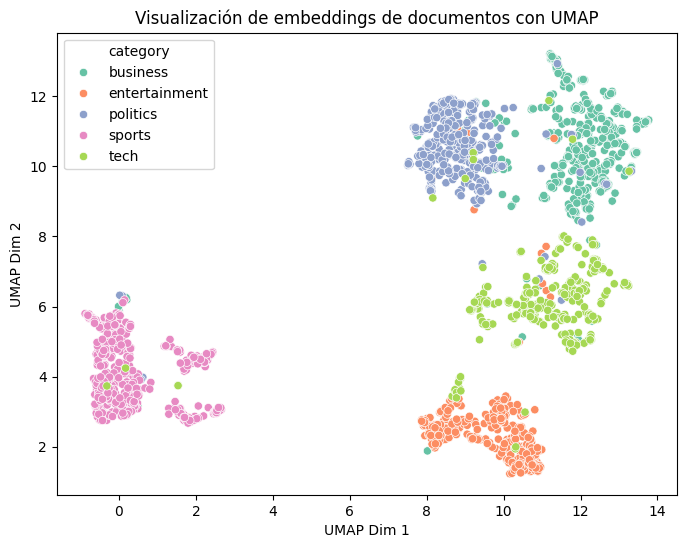

In [25]:
# Generar embeddings
X_train_embeddings = model.encode(df_train["processed_text"])
X_test_embeddings = model.encode(df_test["processed_text"])

# Reducir dimensionalidad con UMAP
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine")
X_reduced = reducer.fit_transform(X_train_embeddings)

# Graficar
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df_train["category"], palette="Set2")
plt.title("Visualización de embeddings de documentos con UMAP")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.show()

## LDA

In [26]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train_tfidf)

# Mostrar las palabras más representativas de cada tema
for idx, topic in enumerate(lda.components_):
    print(f"Tema {df_train['category'].unique()[idx]}: {[feature_names[i] for i in topic.argsort()[-10:]]}")

Tema business: ['slowdown', 'fall', 'price', 'export', 'economist', 'rise', 'dollar', 'economi', 'growth', 'rate']
Tema entertainment: ['viotti', 'cabir', 'blu', 'hendrix', 'euronext', 'tobacco', 'marsh', 'deutsch', 'boer', 'lse']
Tema politics: ['govern', 'also', 'make', 'new', 'peopl', 'would', 'film', 'year', 'mr', 'say']
Tema sports: ['ebber', 'beat', 'fiat', 'round', 'tenni', 'roddick', 'australian', 'gm', 'open', 'seed']
Tema tech: ['side', 'cup', 'good', 'team', 'club', 'player', 'play', 'win', 'game', 'england']


# BERT (supervisado)

In [34]:
import torch

print(torch.cuda.is_available())

True


In [35]:
# -----------------------------------------------------
# 1) Definición del Dataset y preparación de datos
# -----------------------------------------------------

import torch
from torch.utils.data import Dataset


class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

In [36]:
# -----------------------------------------------------
# 2) Definir la función de métricas (compute_metrics)
# -----------------------------------------------------

import numpy as np
from evaluate import load

metric_accuracy = load("accuracy")
metric_f1 = load("f1")
metric_precision = load("precision")
metric_recall = load("recall")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "eval_accuracy": metric_accuracy.compute(
            predictions=predictions, references=labels
        )["accuracy"],
        "eval_f1": metric_f1.compute(
            predictions=predictions, references=labels, average="weighted"
        )["f1"],
        "eval_precision": metric_precision.compute(
            predictions=predictions, references=labels, average="weighted"
        )["precision"],
        "eval_recall": metric_recall.compute(
            predictions=predictions, references=labels, average="weighted"
        )["recall"],
    }

In [37]:
# -----------------------------------------------------
# 3) Preparar los datos (train, val, test)
# -----------------------------------------------------
# Suponiendo que tienes las variables: texts_train, labels_train, texts_val, labels_val, texts_test, labels_test

# Para BERT
from transformers import BertTokenizer

tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = NewsDataset(texts_train, labels_train, tokenizer_bert, max_len=512)
val_dataset = NewsDataset(texts_val, labels_val, tokenizer_bert, max_len=512)
test_dataset = NewsDataset(texts_test, labels_test, tokenizer_bert, max_len=512)

In [38]:
# -----------------------------------------------------
# 4) Entrenamiento y evaluación de BERT
# -----------------------------------------------------

from transformers import BertForSequenceClassification, TrainingArguments, Trainer

model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=5
)
training_args_bert = TrainingArguments(
    output_dir="./results_BERT",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    logging_dir="./logs_BERT",
    logging_steps=50,
)
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print(">>> Entrenando modelo BERT...")
trainer_bert.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> Entrenando modelo BERT...


TrainOutput(global_step=4040, training_loss=0.05143154542316858, metrics={'train_runtime': 1162.6781, 'train_samples_per_second': 27.729, 'train_steps_per_second': 3.475, 'total_flos': 8482928913039360.0, 'train_loss': 0.05143154542316858, 'epoch': 20.0})

In [39]:
print(">>> Evaluando modelo BERT en test...")
results_bert = trainer_bert.evaluate(test_dataset)
print("Resultados en test (BERT):", results_bert)

>>> Evaluando modelo BERT en test...


Resultados en test (BERT): {'eval_accuracy': 0.9904761904761905, 'eval_f1': 0.9904846076066022, 'eval_precision': 0.9907231709888257, 'eval_recall': 0.9904761904761905, 'eval_loss': 0.1038648784160614, 'eval_runtime': 2.5719, 'eval_samples_per_second': 81.651, 'eval_steps_per_second': 10.498, 'epoch': 20.0}


In [40]:
model_bert.save_pretrained("./models/modelBERT")
tokenizer_bert.save_pretrained("./models/modelBERT")

('./models/modelBERT\\tokenizer_config.json',
 './models/modelBERT\\special_tokens_map.json',
 './models/modelBERT\\vocab.txt',
 './models/modelBERT\\added_tokens.json')

In [41]:
# -----------------------------------------------------
# 5) Entrenamiento y evaluación de ALBERT
# -----------------------------------------------------

from transformers import AlbertTokenizer, AlbertForSequenceClassification

tokenizer_albert = AlbertTokenizer.from_pretrained("albert-base-v2")
train_dataset_albert = NewsDataset(
    texts_train, labels_train, tokenizer_albert, max_len=512
)
val_dataset_albert = NewsDataset(texts_val, labels_val, tokenizer_albert, max_len=512)
test_dataset_albert = NewsDataset(
    texts_test, labels_test, tokenizer_albert, max_len=512
)

model_albert = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2", num_labels=5
)
training_args_albert = TrainingArguments(
    output_dir="./results_ALBERT",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    logging_dir="./logs_ALBERT",
    logging_steps=50,
)
trainer_albert = Trainer(
    model=model_albert,
    args=training_args_albert,
    train_dataset=train_dataset_albert,
    eval_dataset=val_dataset_albert,
    compute_metrics=compute_metrics,
)

print(">>> Entrenando modelo ALBERT...")
trainer_albert.train()

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> Entrenando modelo ALBERT...


TrainOutput(global_step=4040, training_loss=0.13682216521384802, metrics={'train_runtime': 1166.5178, 'train_samples_per_second': 27.638, 'train_steps_per_second': 3.463, 'total_flos': 770703288975360.0, 'train_loss': 0.13682216521384802, 'epoch': 20.0})

In [42]:
print(">>> Evaluando modelo ALBERT en test...")
results_albert = trainer_albert.evaluate(test_dataset_albert)
print("Resultados en test (ALBERT):", results_albert)

>>> Evaluando modelo ALBERT en test...


Resultados en test (ALBERT): {'eval_accuracy': 0.9952380952380953, 'eval_f1': 0.9952434396878841, 'eval_precision': 0.9953542392566783, 'eval_recall': 0.9952380952380953, 'eval_loss': 0.04743221029639244, 'eval_runtime': 2.5373, 'eval_samples_per_second': 82.766, 'eval_steps_per_second': 10.641, 'epoch': 20.0}


In [43]:
model_albert.save_pretrained("./models/modelALBERT")
tokenizer_albert.save_pretrained("./models/modelALBERT")

('./models/modelALBERT\\tokenizer_config.json',
 './models/modelALBERT\\special_tokens_map.json',
 './models/modelALBERT\\spiece.model',
 './models/modelALBERT\\added_tokens.json')

In [44]:
# -----------------------------------------------------
# 6) Entrenamiento y evaluación de RoBERTa
# -----------------------------------------------------

from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer_roberta = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset_roberta = NewsDataset(
    texts_train, labels_train, tokenizer_roberta, max_len=512
)
val_dataset_roberta = NewsDataset(texts_val, labels_val, tokenizer_roberta, max_len=512)
test_dataset_roberta = NewsDataset(
    texts_test, labels_test, tokenizer_roberta, max_len=512
)

model_roberta = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=5
)
training_args_roberta = TrainingArguments(
    output_dir="./results_RoBERTa",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    logging_dir="./logs_RoBERTa",
    logging_steps=50,
)
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    compute_metrics=compute_metrics,
)

print(">>> Entrenando modelo RoBERTa...")
trainer_roberta.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> Entrenando modelo RoBERTa...


TrainOutput(global_step=4040, training_loss=0.06061588470791789, metrics={'train_runtime': 1063.0732, 'train_samples_per_second': 30.327, 'train_steps_per_second': 3.8, 'total_flos': 8482928913039360.0, 'train_loss': 0.06061588470791789, 'epoch': 20.0})

In [45]:
print(">>> Evaluando modelo RoBERTa en test...")
results_roberta = trainer_roberta.evaluate(test_dataset_roberta)
print("Resultados en test (RoBERTa):", results_roberta)

>>> Evaluando modelo RoBERTa en test...


Resultados en test (RoBERTa): {'eval_accuracy': 0.9904761904761905, 'eval_f1': 0.9904761904761905, 'eval_precision': 0.9904761904761905, 'eval_recall': 0.9904761904761905, 'eval_loss': 0.07216928899288177, 'eval_runtime': 2.1717, 'eval_samples_per_second': 96.696, 'eval_steps_per_second': 12.432, 'epoch': 20.0}


In [46]:
model_roberta.save_pretrained("./models/modelRoBERTa")
tokenizer_roberta.save_pretrained("./models/modelRoBERTa")

('./models/modelRoBERTa\\tokenizer_config.json',
 './models/modelRoBERTa\\special_tokens_map.json',
 './models/modelRoBERTa\\vocab.json',
 './models/modelRoBERTa\\merges.txt',
 './models/modelRoBERTa\\added_tokens.json')



=== COMPARACIÓN FINAL DE MODELOS ===


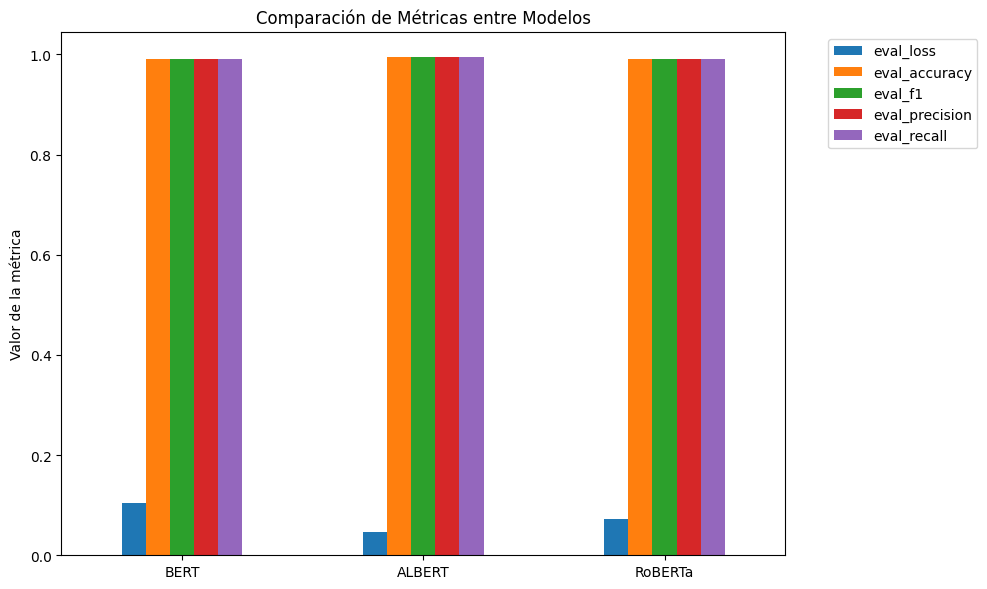

In [47]:
# -----------------------------------------------------
# 7) Recopilación de resultados y gráfica comparativa
# -----------------------------------------------------

# Crear un diccionario con los resultados de evaluación de cada modelo
evaluation_results = {
    "BERT": results_bert,
    "ALBERT": results_albert,
    "RoBERTa": results_roberta,
}

import pandas as pd
import matplotlib.pyplot as plt


def plot_model_results(evaluation_results):
    """
    Genera una gráfica comparativa de las métricas de evaluación para cada modelo.
    El diccionario evaluation_results debe tener la siguiente estructura:
        {
            "BERT": {"eval_loss": ..., "eval_accuracy": ..., "eval_f1": ..., ...},
            "ALBERT": {"eval_loss": ..., "eval_accuracy": ..., "eval_f1": ..., ...},
            "RoBERTa": {"eval_loss": ..., "eval_accuracy": ..., "eval_f1": ..., ...}
        }
    """
    # Convertir el diccionario en un DataFrame (filas: modelos, columnas: métricas)
    df = pd.DataFrame(evaluation_results).T

    # Seleccionar las métricas a comparar
    metricas_de_interes = [
        "eval_loss",
        "eval_accuracy",
        "eval_f1",
        "eval_precision",
        "eval_recall",
    ]
    metricas_existentes = [m for m in metricas_de_interes if m in df.columns]
    df = df[metricas_existentes]

    # Crear una figura con 1 fila y 3 columnas: Perplexity, otras métricas y Topic Coherence
    # En este ejemplo evaluamos solo las métricas comunes.
    # Si en el futuro añades más métricas (por ejemplo, de modelos no supervisados),
    # podrías adaptar esta función para incluirlas.
    ax = df.plot(kind="bar", figsize=(10, 6))
    ax.set_title("Comparación de Métricas entre Modelos")
    ax.set_ylabel("Valor de la métrica")
    ax.set_xticks(range(len(df.index)))
    ax.set_xticklabels(df.index, rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


print("\n\n=== COMPARACIÓN FINAL DE MODELOS ===")
plot_model_results(evaluation_results)

# Búsqueda del mejor modelo no supervisado (LDA)

## Funciones auxiliares

In [48]:
# Visualización de los temas
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Tema {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Nube de palabras
def plot_wordclouds(model, feature_names, num_topics):
    fig, axes = plt.subplots(1, num_topics, figsize=(15, 5))
    for topic_idx, topic in enumerate(model.components_):
        word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-15 - 1:-1]}
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freq)
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].axis("off")
        axes[topic_idx].set_title(f"Tema {topic_idx+1}")
    plt.show()

def plot_topic_distribution(df, key):
    plt.figure(figsize=(8,5))
    sns.countplot(x=df["assigned_topic"], palette="Set2", hue=df["category"])
    plt.xlabel("Temas asignados por LDA")
    plt.ylabel("Número de documentos")
    plt.title(f"Distribución de documentos por tema - {key}")
    plt.show()

# Comparación entre temas asignados y categorías reales
def plot_category_vs_topic(df, key):
    plt.figure(figsize=(12,6))
    sns.countplot(x=df["assigned_topic"], hue=df["category"], palette="Set2")
    plt.xlabel("Temas asignados por LDA")
    plt.ylabel("Número de documentos")
    plt.title(f"Comparación entre temas asignados y categorías reales - {key}")
    plt.legend(title="Categoría real", bbox_to_anchor=(1,1))
    plt.show()


# Comparación visual de las métricas evaluadas
def plot_results(results):
    # Convertir los resultados en un DataFrame y trasponer
    df_results = pd.DataFrame(results).T

    # Extraer 'ngram_range' desde las claves del índice usando split
    df_results["ngram_range"] = df_results.index.map(lambda x: int(x.split("_")[2]))

    # Obtener valores únicos de ngram_range y ordenarlos
    ngram_ranges = sorted(df_results["ngram_range"].unique())

    # Iterar sobre cada ngram_range
    for ngram_range in ngram_ranges:
        # Filtrar los resultados para el ngram_range actual
        df_ngram = df_results[df_results["ngram_range"] == ngram_range]

        # Crear una figura con 1 fila y 3 columnas para las gráficas
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))

        # Gráfica de Perplexity en la primera columna
        if "perplexity" in df_ngram.columns:
            df_ngram[["perplexity"]].dropna().plot(kind="bar", legend=False, ax=axes[0])
            axes[0].set_title(f"Comparación de Perplexity (ngram_range: {ngram_range})")
            axes[0].set_ylabel("Perplexity")
            axes[0].set_xticks(range(len(df_ngram)))
            axes[0].set_xticklabels(df_ngram.index, rotation=30, ha="right")

        # Gráfica de otras métricas (excluyendo perplexity y topic_coherence) en la segunda columna
        other_metrics = df_ngram.drop(
            columns=["perplexity", "topic_coherence", "ngram_range"], errors="ignore"
        )
        if not other_metrics.empty:
            other_metrics.plot(kind="bar", ax=axes[1])
            axes[1].set_title(
                f"Comparación de otras métricas (ngram_range: {ngram_range})"
            )
            axes[1].set_xticks(range(len(df_ngram)))
            axes[1].set_xticklabels(df_ngram.index, rotation=30, ha="right")

        # Gráfica de Topic Coherence en la tercera columna
        if "topic_coherence" in df_ngram.columns:
            df_ngram[["topic_coherence"]].dropna().plot(
                kind="bar", legend=False, ax=axes[2]
            )
            axes[2].set_title(
                f"Comparación de Coherencia de Tópicos (ngram_range: {ngram_range})"
            )
            axes[2].set_ylabel("Topic Coherence")
            axes[2].set_xticks(range(len(df_ngram)))
            axes[2].set_xticklabels(df_ngram.index, rotation=30, ha="right")

        # Ajustar el diseño
        plt.tight_layout()
        plt.show()

## Métricas a evaluar

In [49]:
# Función para evaluar Perplexity
def lda_perplexity_score(model, X):
    return -model.perplexity(X)  # Negativo porque GridSearchCV maximiza la métrica

# Función para calcular Purity Score
def purity_score(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

# Métrica personalizada para GridSearchCV
def lda_purity_scorer(estimator, X, y_true):
    assigned_topics = np.argmax(estimator.transform(X), axis=1)
    return purity_score(y_true, assigned_topics)

import numpy as np
import math
from collections import defaultdict

def compute_topic_coherence_no_gensim(lda_model, vectorizer, texts, top_n=15):
    """
    Calcula la coherencia de tópicos usando la métrica c_umass sin gensim.

    Parámetros:
      - lda_model: Modelo LDA entrenado (sklearn).
      - vectorizer: El vectorizador usado (CountVectorizer o TfidfVectorizer).
      - texts: Lista de documentos tokenizados (lista de listas de tokens).
      - top_n: Número de palabras a considerar por tópico.

    Retorna:
      - coherence: Valor promedio de coherencia c_umass para todos los tópicos.
    """
    # Extraer nombres de características y definir los tópicos
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[: -top_n - 1 : -1]]
        topics.append(topic_words)

    # Crear contadores de frecuencia: para cada palabra, cuántos documentos la contienen
    # y para cada par de palabras, cuántos documentos las contienen conjuntamente.
    doc_freq = defaultdict(int)
    pair_freq = defaultdict(int)

    # Convertir cada documento a un conjunto para evitar contar repeticiones
    docs = [set(doc) for doc in texts]

    for doc in docs:
        for word in doc:
            doc_freq[word] += 1
        doc_list = list(doc)
        for i in range(len(doc_list)):
            for j in range(i + 1, len(doc_list)):
                # Ordenamos la pareja para tener una clave única
                key = tuple(sorted([doc_list[i], doc_list[j]]))
                pair_freq[key] += 1

    # Calcular c_umass para cada tópico
    topic_coherences = []
    for topic_words in topics:
        score = 0.0
        pair_count = 0
        # Se consideran pares (w_i, w_j) con i > j
        for i in range(1, len(topic_words)):
            for j in range(0, i):
                w_i = topic_words[i]
                w_j = topic_words[j]
                key = tuple(sorted([w_i, w_j]))
                # Usamos la frecuencia de w_i como denominador (podrías usar w_j, según la definición)
                D_wi = doc_freq[w_i]
                D_wi_wj = pair_freq.get(key, 0)
                if D_wi > 0:
                    score += np.log((D_wi_wj + 1) / D_wi)
                    pair_count += 1
        if pair_count > 0:
            topic_coherences.append(score / pair_count)

    if topic_coherences:
        return np.mean(topic_coherences)
    else:
        return 0.0

perplexity_scorer = make_scorer(lda_perplexity_score, greater_is_better=True)

## Búsqueda de 5 temas

In [50]:
# Función para representar texto con diferentes n-gramas
def represent_text(df, method, ngram_range=(1,1), max_features=1000):
    processed_str = df["processed"].apply(lambda x: " ".join(x))

    if method == "bow":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    else:
        raise ValueError("Método no válido")

    return vectorizer, vectorizer.fit_transform(processed_str)

In [51]:
# Evaluación en df_test con GridSearchCV usando n-gramas
representations = ["bow", "tfidf"]
n_gram_ranges = [(1,1), (1,2), (1,3)]
max_features = [500, 1000, 1500, 2000]

param_grid = {"learning_decay": [0.3, 0.5, 0.7, 0.9]}
results = {}
models = {}

# --- En el bucle de GridSearch, reemplazamos la llamada a compute_topic_coherence por la versión sin gensim

for rep in representations:
    for max_feature in max_features:
        for ngram_range in n_gram_ranges:
            vectorizer, X_train = represent_text(
                df_train, method=rep, ngram_range=ngram_range, max_features=max_feature
            )
            X_test = vectorizer.transform(df_test["processed_text"])

            grid_search = GridSearchCV(
                LatentDirichletAllocation(n_components=5, random_state=42),
                param_grid,
                cv=5,
                n_jobs=-1,
                verbose=1,
                scoring=lda_purity_scorer,
            )
            grid_search.fit(X_train, df_train["category"])
            best_lda = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_

            print(
                f"Mejores hiperparámetros para {rep} con n-gramas {ngram_range}: {best_params}"
            )

            perplexity = best_lda.perplexity(X_test)

            # Diversidad de temas
            assigned_topics = np.argmax(best_lda.transform(X_test), axis=1)

            # Divergencia de Jensen-Shannon
            topic_distributions = best_lda.transform(X_test)
            js_divergence = np.mean(
                [
                    jensenshannon(topic_distributions[i], topic_distributions[j])
                    for i in range(len(topic_distributions))
                    for j in range(i + 1, len(topic_distributions))
                ]
            )

            # Purity Score
            purity = purity_score(df_test["category"], assigned_topics)

            # Calcular Topic Coherence sin gensim, usando los textos tokenizados del train
            # Se asume que df_train["processed"] es una columna de listas de tokens.
            topic_coherence = compute_topic_coherence_no_gensim(
                best_lda, vectorizer, df_train["processed"].tolist()
            )

            # Almacenar todos los resultados en el diccionario results
            key = f"{rep}_ngram_{ngram_range[1]}_maxfeature_{max_feature}"
            results[key] = {
                "perplexity": perplexity,
                "js_divergence": js_divergence,
                "purity_score": purity,
                "topic_coherence": topic_coherence,
            }

            models[key] = {"model": best_lda, "params": best_params, "score": purity}

            print(
                f"\nRepresentación: {rep} con n-gramas {ngram_range} - Perplexity: {perplexity},"
            )
            print(
                f"JS Divergence: {js_divergence},"
            )
            print(f"Purity Score: {purity}, Topic Coherence: {topic_coherence}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros para bow con n-gramas (1, 1): {'learning_decay': 0.3}

Representación: bow con n-gramas (1, 1) - Perplexity: 373.81716985316035,
JS Divergence: 0.6325553945306714,
Purity Score: 0.9142857142857143, Topic Coherence: -0.9851195845654319
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros para bow con n-gramas (1, 2): {'learning_decay': 0.3}

Representación: bow con n-gramas (1, 2) - Perplexity: 385.45820922553014,
JS Divergence: 0.6124360729805076,
Purity Score: 0.6952380952380952, Topic Coherence: -0.857909414241503
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros para bow con n-gramas (1, 3): {'learning_decay': 0.3}

Representación: bow con n-gramas (1, 3) - Perplexity: 385.45820922553014,
JS Divergence: 0.6124360729805076,
Purity Score: 0.6952380952380952, Topic Coherence: -0.857909414241503
Fitting 5 folds for each of 4 candidates, tot

## Evaluación

In [54]:
df_results = pd.DataFrame(results)
df_results.to_csv('csv_files/results/results_lda.csv')
df_results

bow_ngram_1_maxfeature_500  bow_ngram_2_maxfeature_500  \
perplexity                       373.817170                  385.458209   
js_divergence                      0.632555                    0.612436   
purity_score                       0.914286                    0.695238   
topic_coherence                   -0.985120                   -0.857909   

                 bow_ngram_3_maxfeature_500  bow_ngram_1_maxfeature_1000  \
perplexity                       385.458209                   720.807104   
js_divergence                      0.612436                     0.634811   
purity_score                       0.695238                     0.933333   
topic_coherence                   -0.857909                    -0.934714   

                 bow_ngram_2_maxfeature_1000  bow_ngram_3_maxfeature_1000  \
perplexity                        736.760491                   718.660899   
js_divergence                       0.613264                     0.636272   
purity_score                        0.828571                     0.928571   
topic_coherence                    -0.935779                    -0.947475   

                 bow_ngram_1_maxfeature_1500  bow_ngram_2_maxfeature_1500  \
perplexity                       1101.186858                  1051.654354   
js_divergence                       0.617138                     0.638180   
purity_score                        0.723810                     0.952381   
topic_coherence                    -0.891266                    -0.944643   

                 bow_ngram_3_maxfeature_1500  bow_ngram_1_maxfeature_2000  \
perplexity                       1060.973150                  1457.881901   
js_divergence                       0.634617                     0.593055   
purity_score                        0.919048                     0.571429   
topic_coherence                    -0.922710                    -0.933867   

                 ...  tfidf_ngram_3_maxfeature_500  \
perplexity       ...                   4833.775064   
js_divergence    ...                      0.504167   
purity_score     ...                      0.757143   
topic_coherence  ...                     -1.413919   

                 tfidf_ngram_1_maxfeature_1000  tfidf_ngram_2_maxfeature_1000  \
perplexity                        23287.162635                   19766.898681   
js_divergence                         0.514579                       0.522709   
purity_score                          0.719048                       0.819048   
topic_coherence                      -1.271371                      -1.376927   

                 tfidf_ngram_3_maxfeature_1000  tfidf_ngram_1_maxfeature_1500  \
perplexity                        18810.024028                   37753.252760   
js_divergence                         0.501595                       0.484896   
purity_score                          0.714286                       0.604762   
topic_coherence                      -1.548545                      -1.710805   

                 tfidf_ngram_2_maxfeature_1500  tfidf_ngram_3_maxfeature_1500  \
perplexity                        34461.164742                   74520.942629   
js_divergence                         0.433333                       0.535477   
purity_score                          0.633333                       0.776190   
topic_coherence                      -1.590457                      -1.140235   

                 tfidf_ngram_1_maxfeature_2000  tfidf_ngram_2_maxfeature_2000  \
perplexity                        54706.176562                   68711.581801   
js_divergence                         0.396502                       0.449087   
purity_score                          0.476190                       0.566667   
topic_coherence                      -1.606989                      -1.694091   

                 tfidf_ngram_3_maxfeature_2000  
perplexity                        63625.416081  
js_divergence                         0.452124  
purity_score                          0.633333  
topic_coher

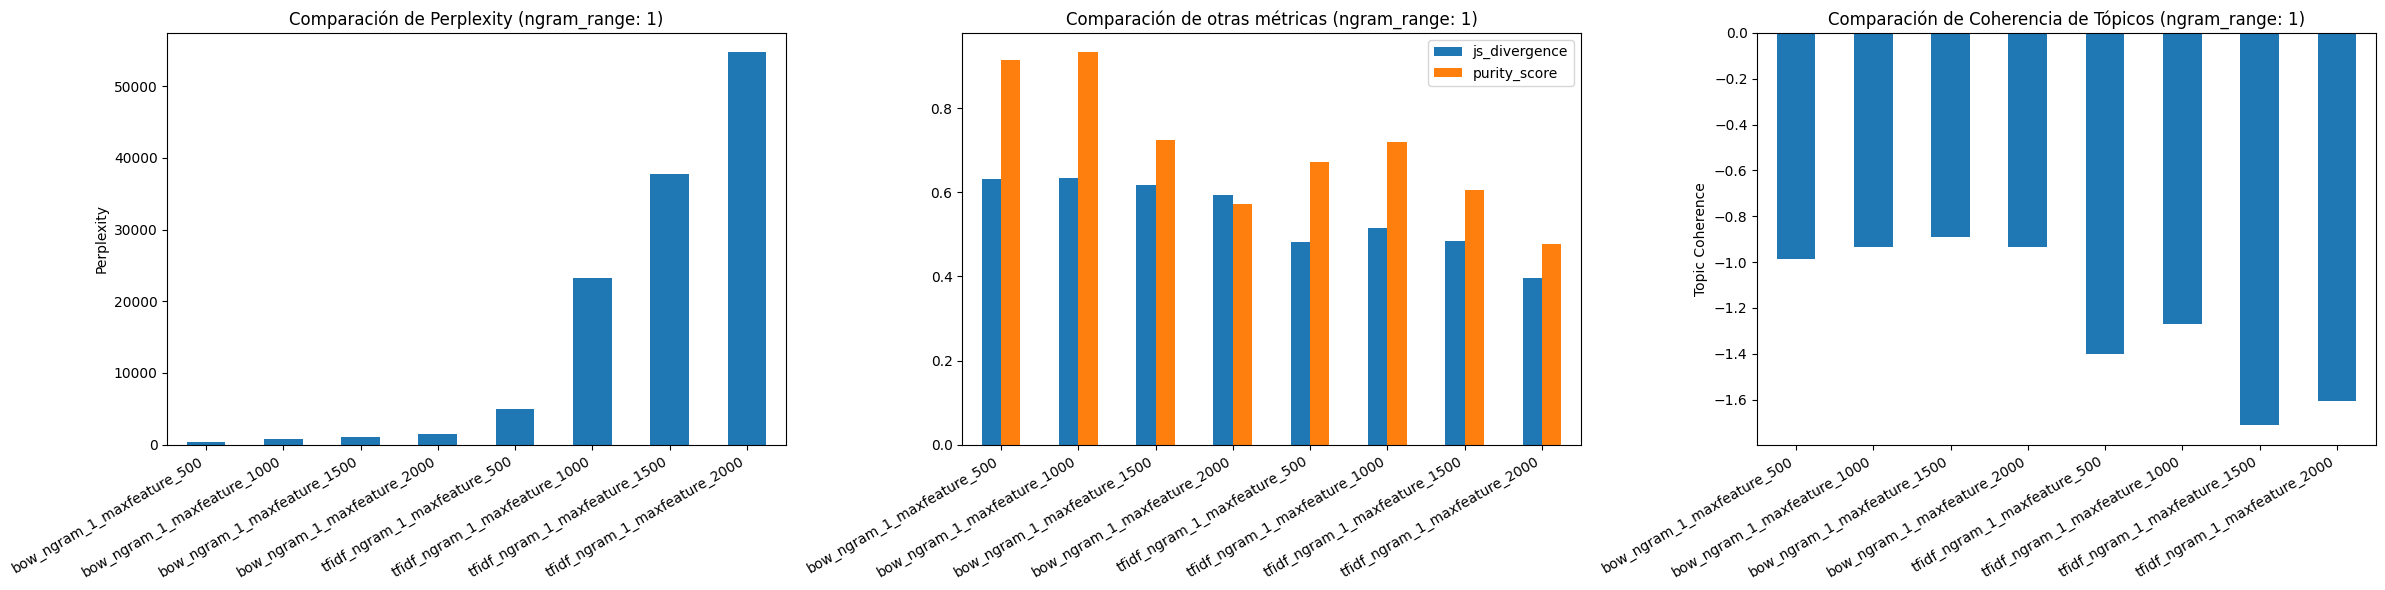

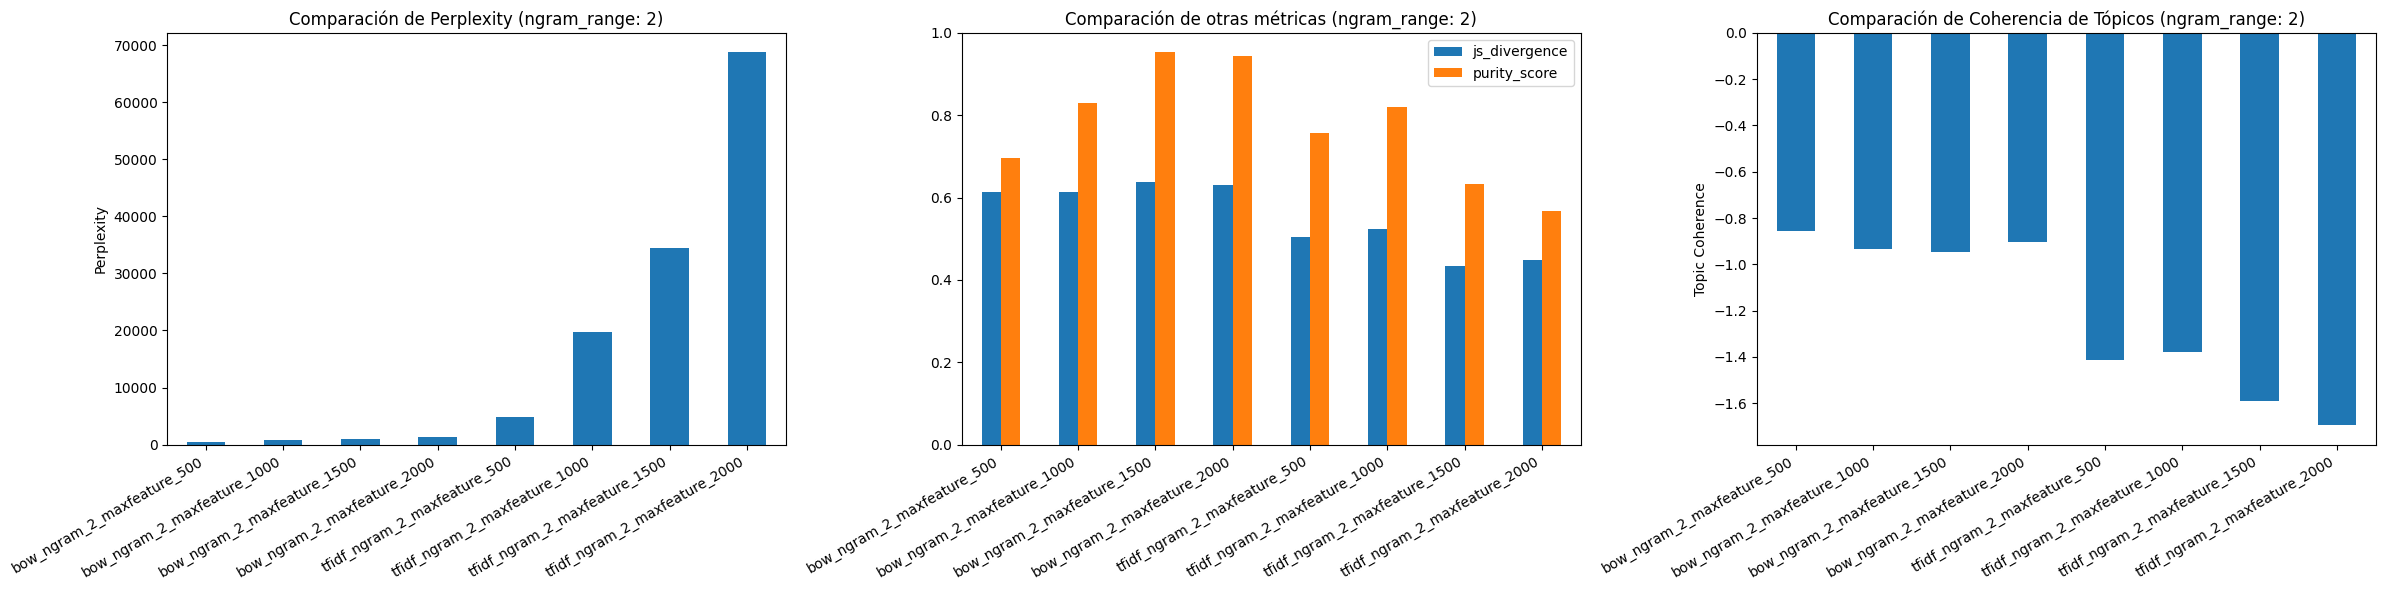

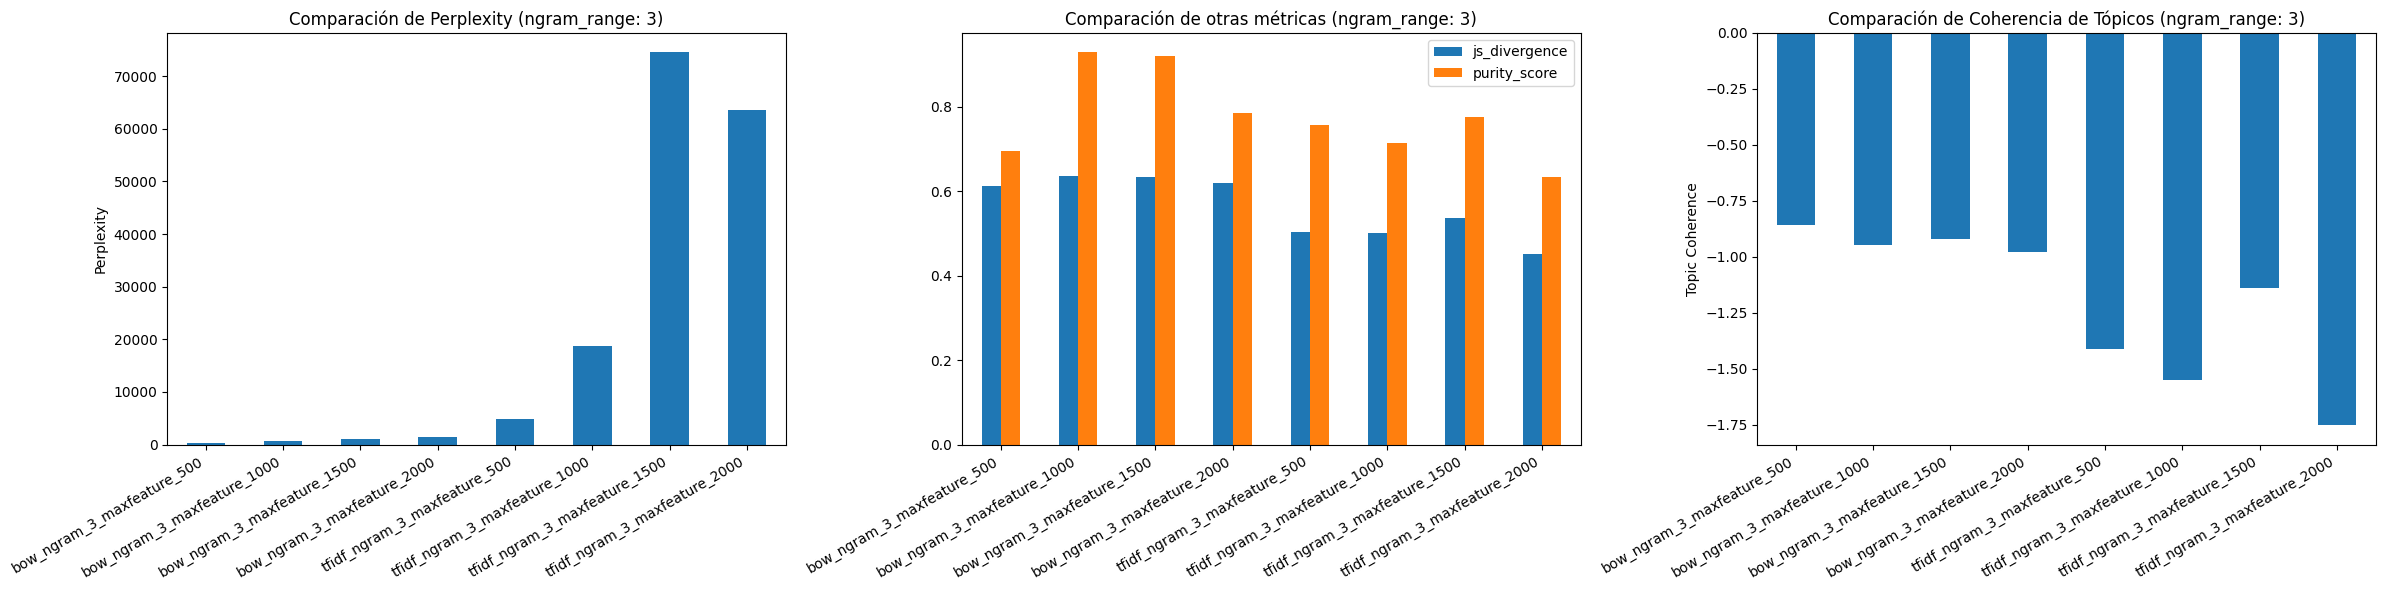

In [55]:
plot_results(results)



Graphics bow_ngram_1_maxfeature_500




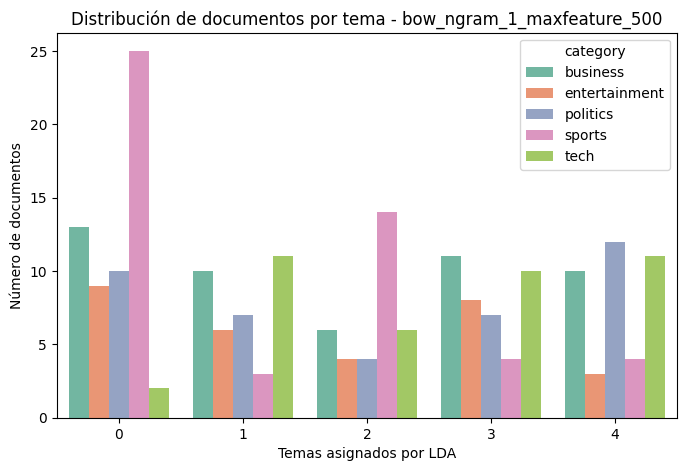

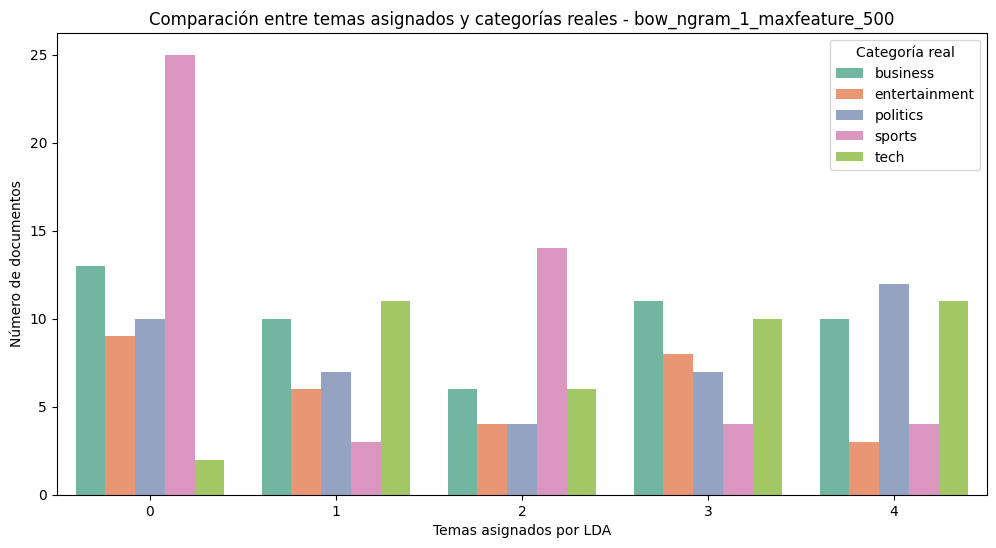

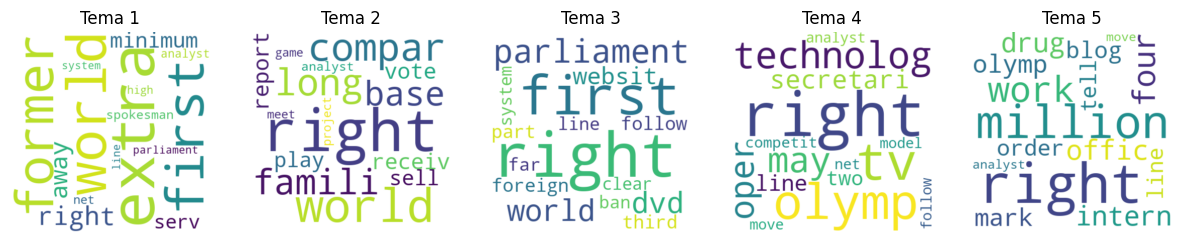



Graphics bow_ngram_2_maxfeature_500




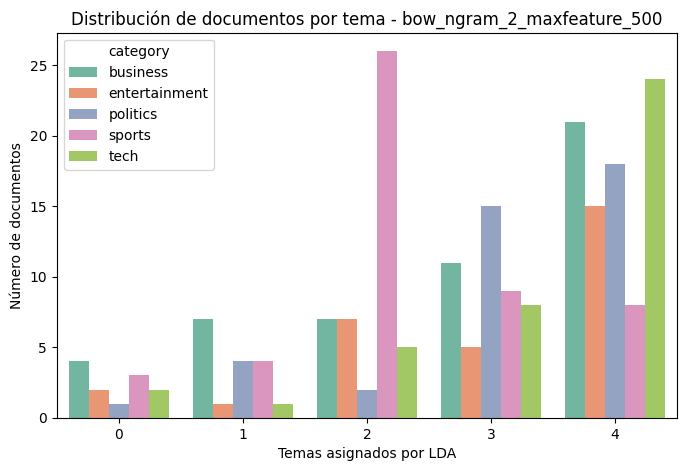

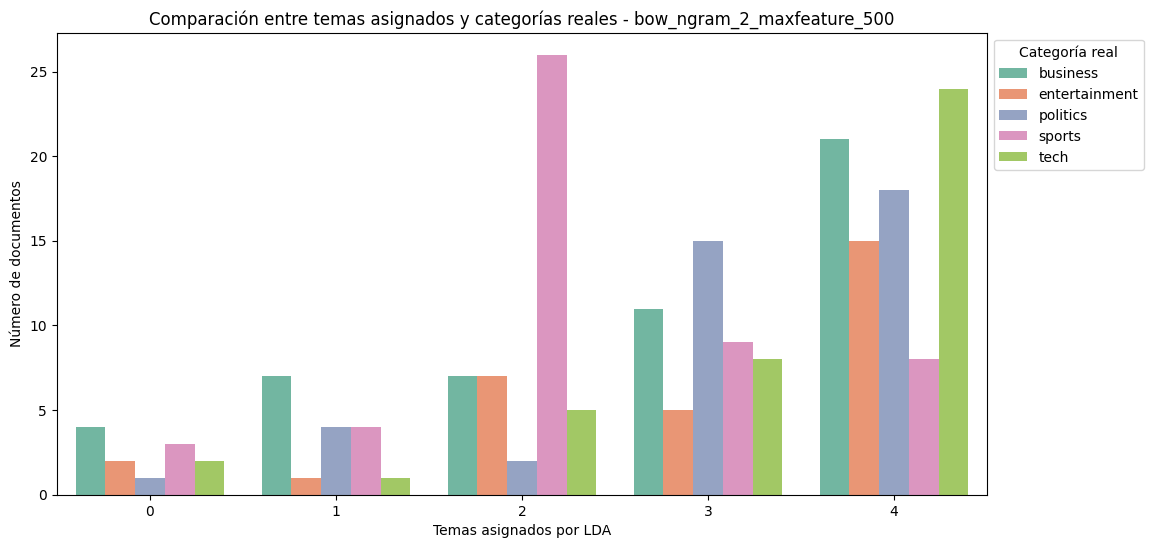

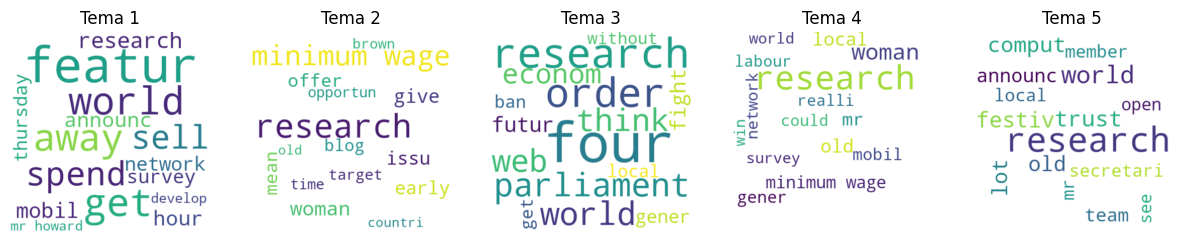



Graphics bow_ngram_3_maxfeature_500




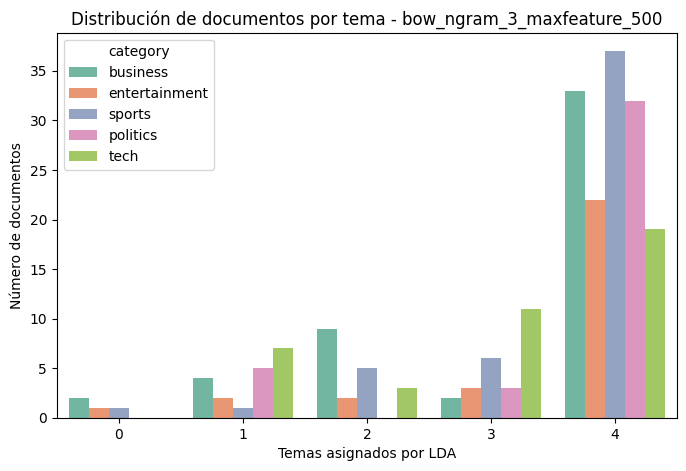

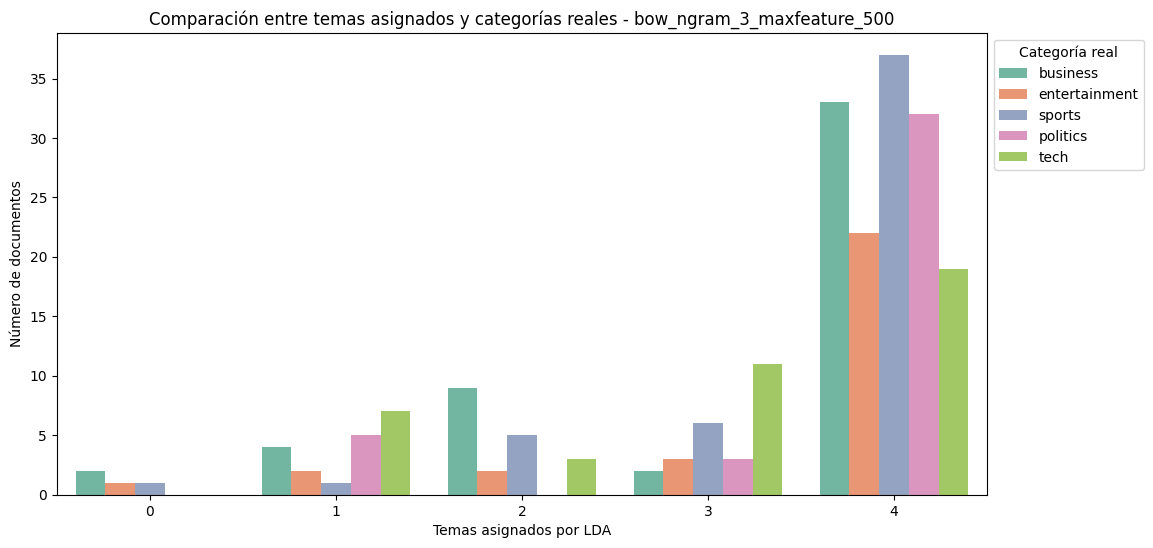

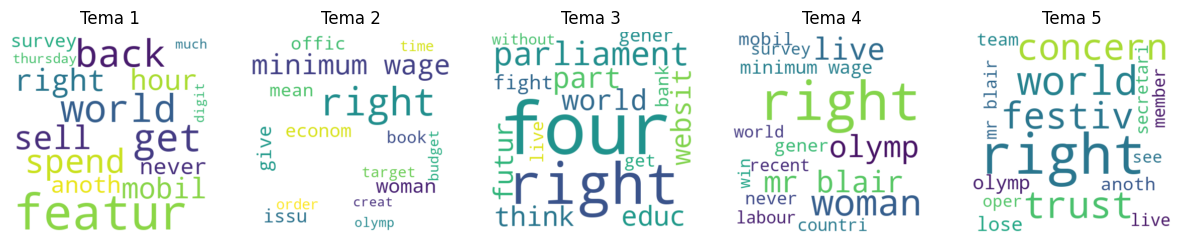



Graphics bow_ngram_1_maxfeature_1000




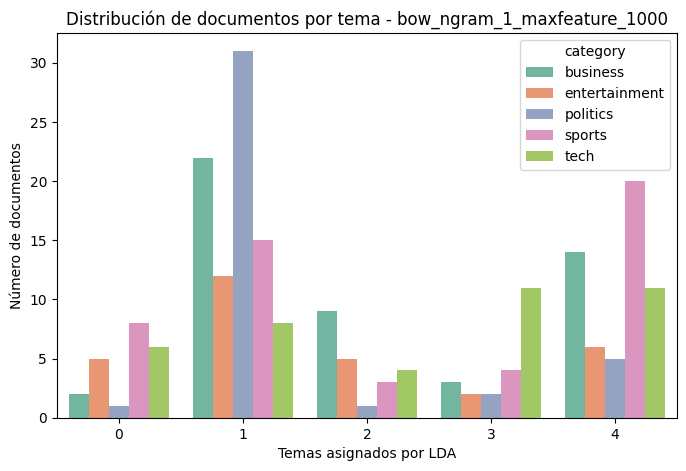

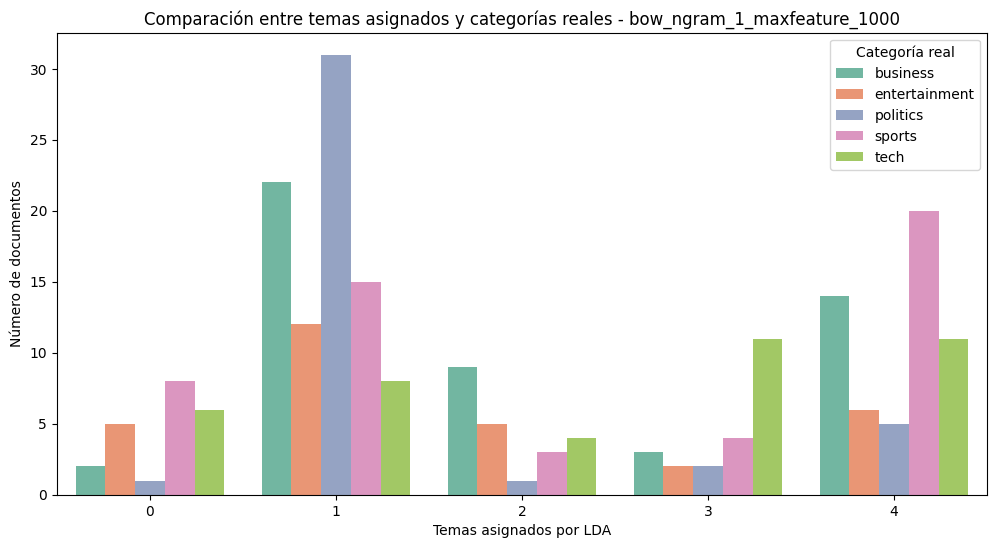

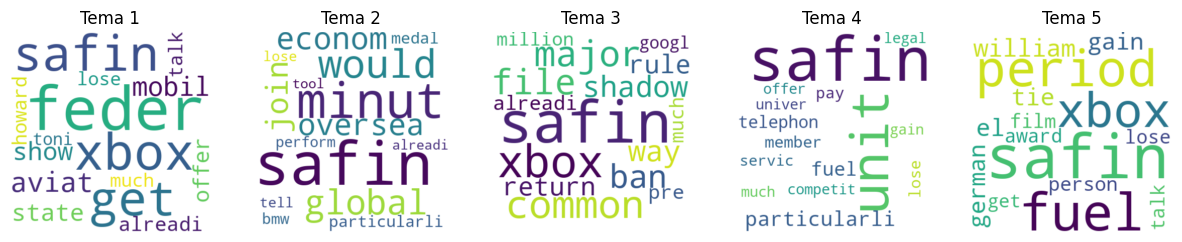



Graphics bow_ngram_2_maxfeature_1000




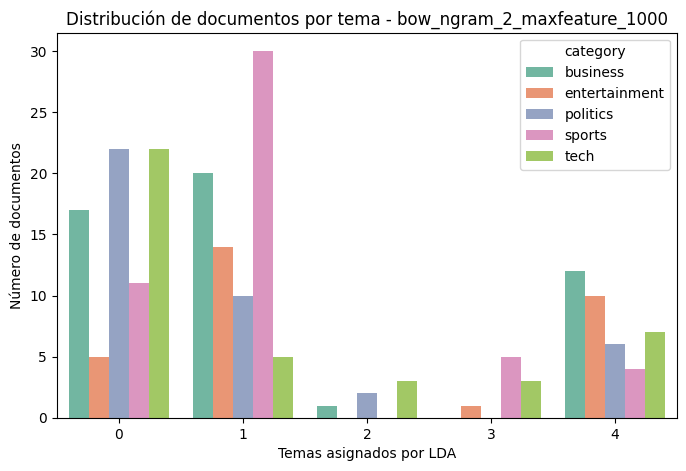

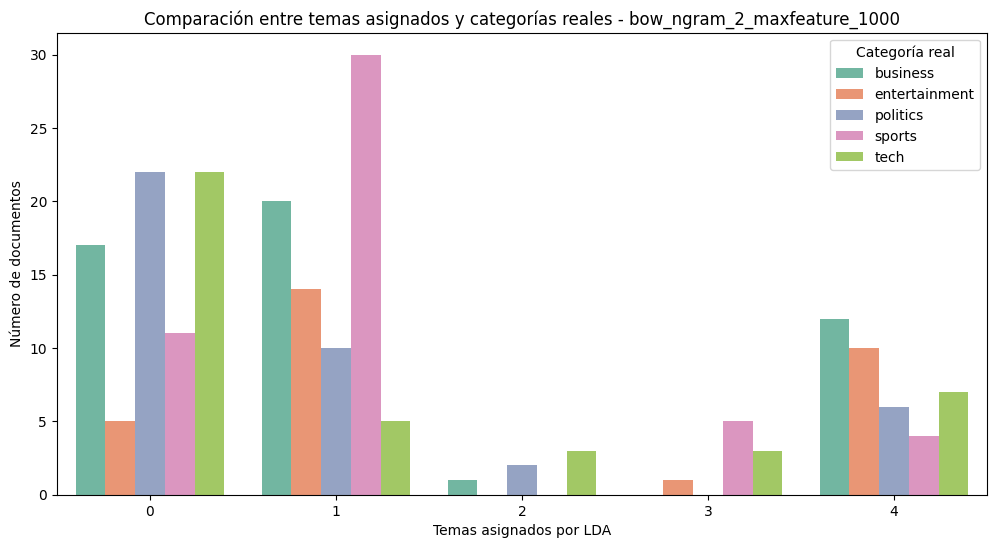

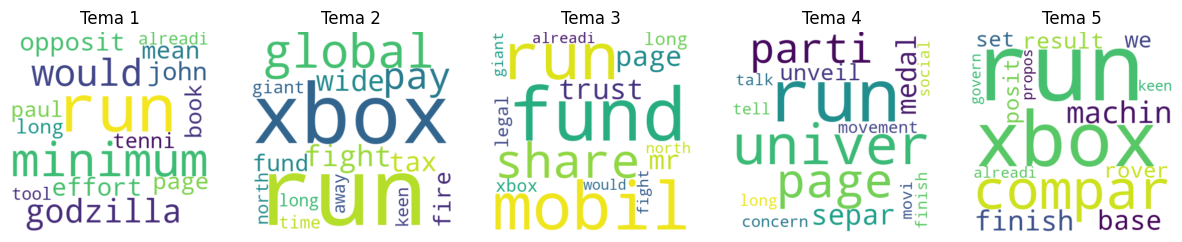



Graphics bow_ngram_3_maxfeature_1000




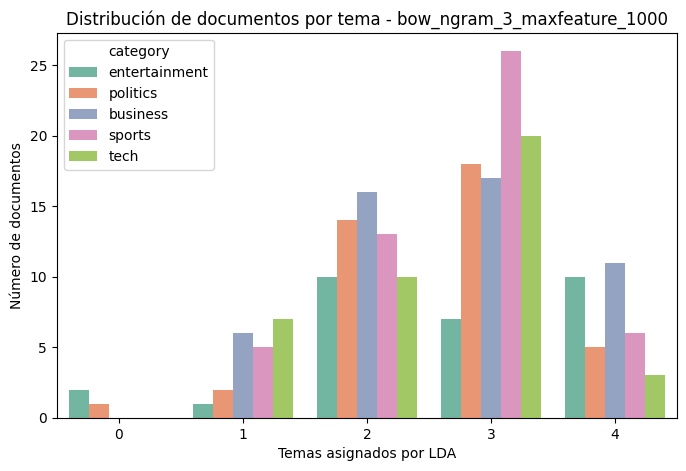

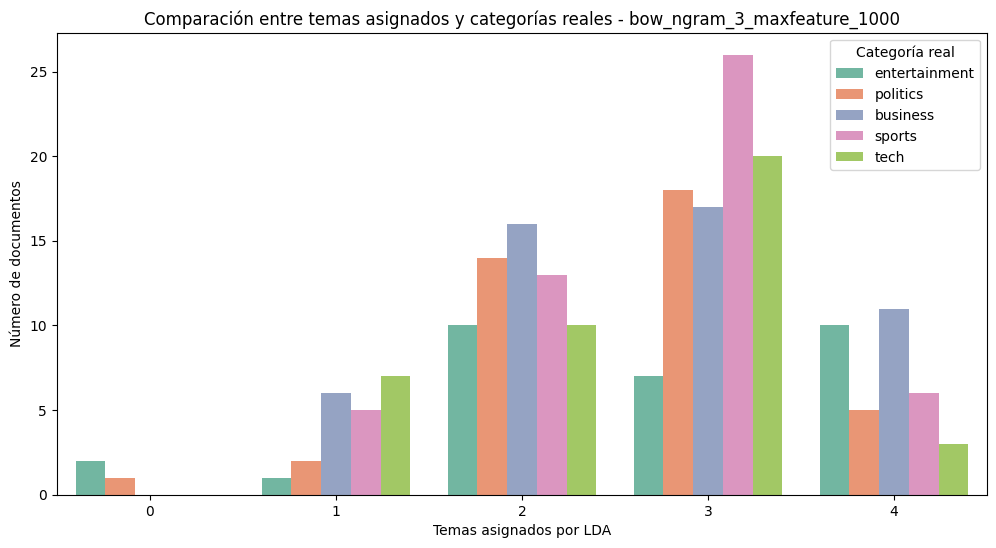

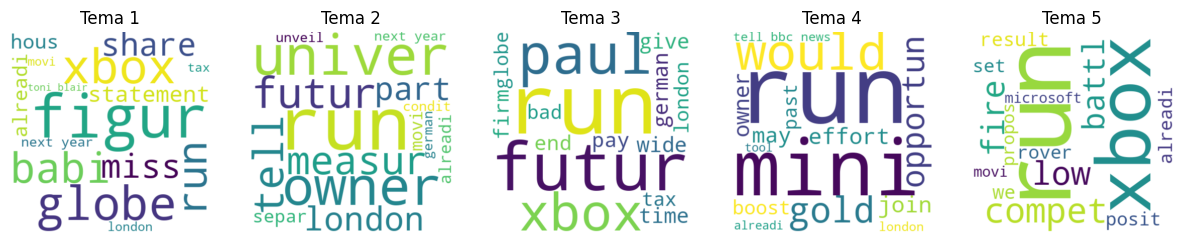



Graphics bow_ngram_1_maxfeature_1500




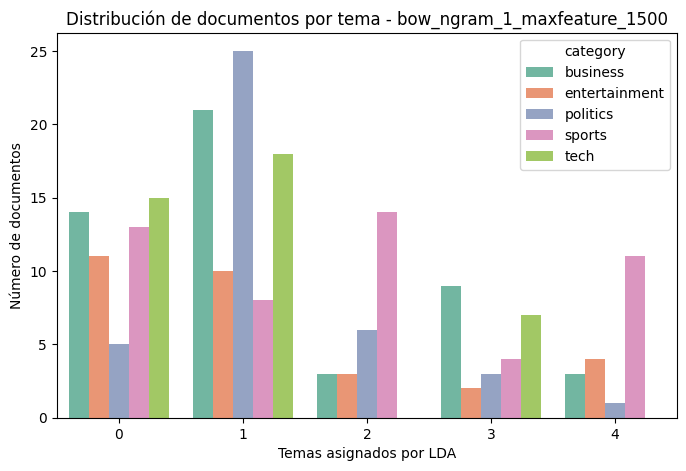

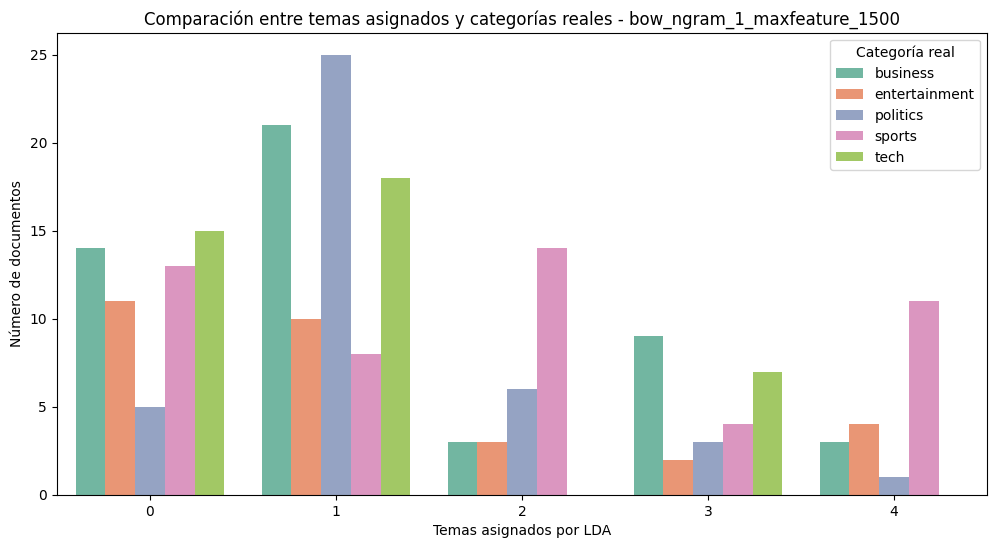

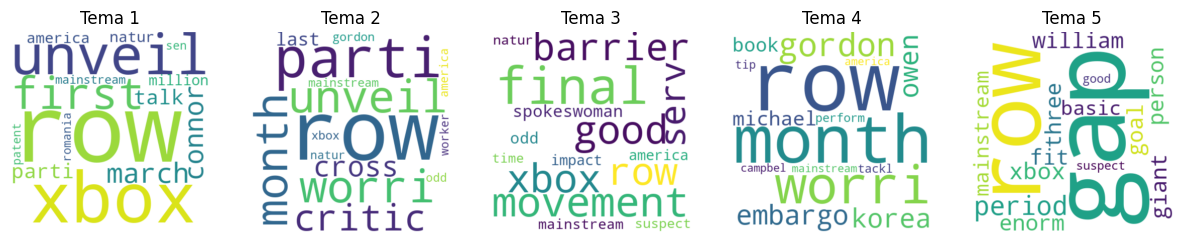



Graphics bow_ngram_2_maxfeature_1500




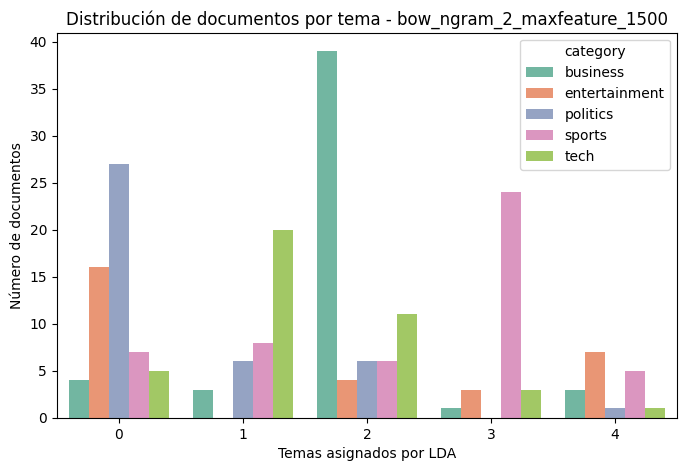

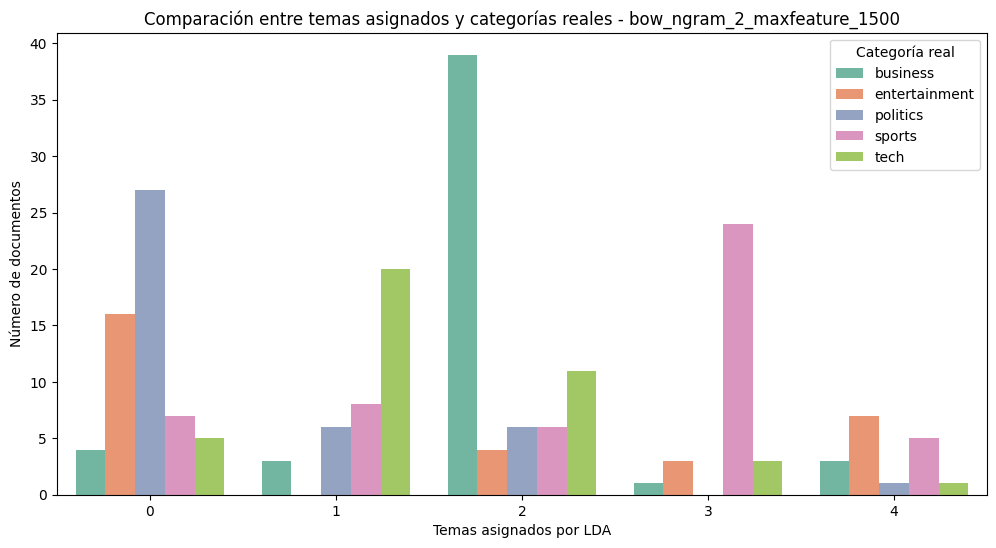

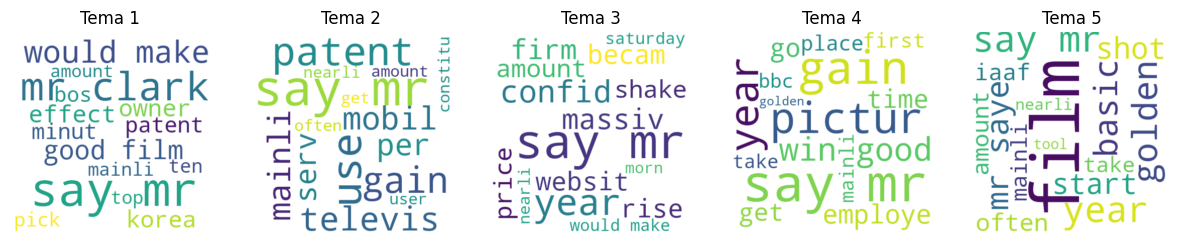



Graphics bow_ngram_3_maxfeature_1500




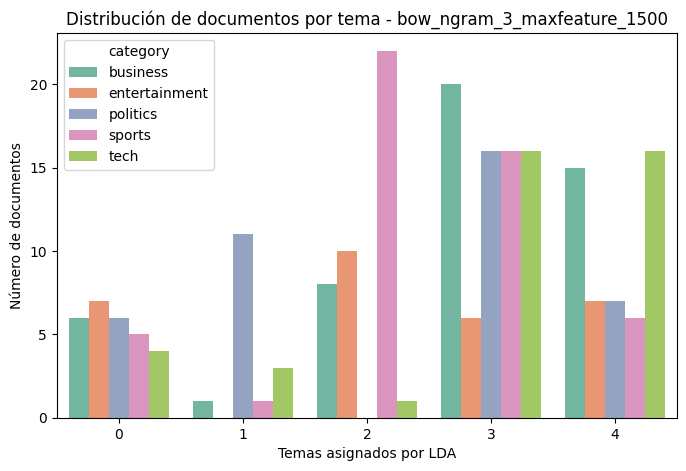

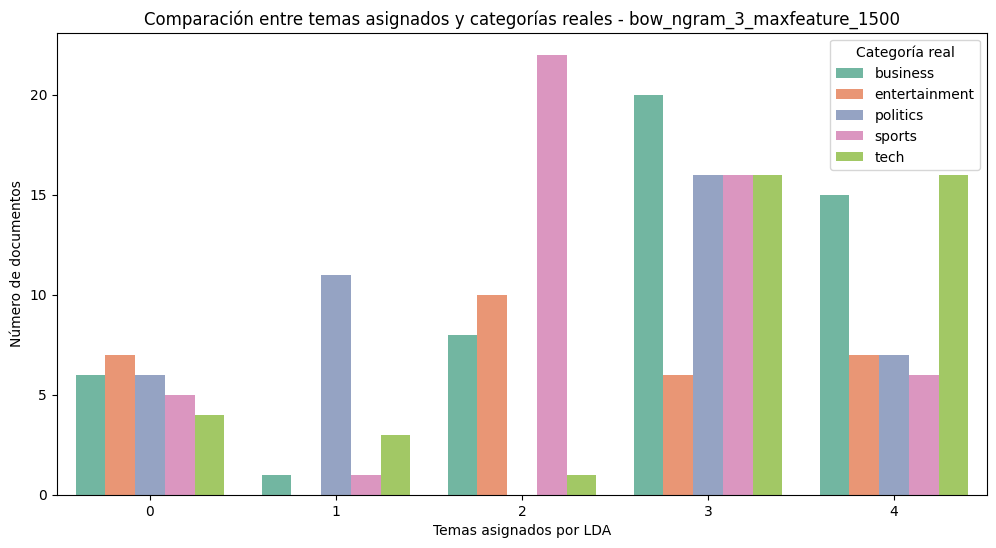

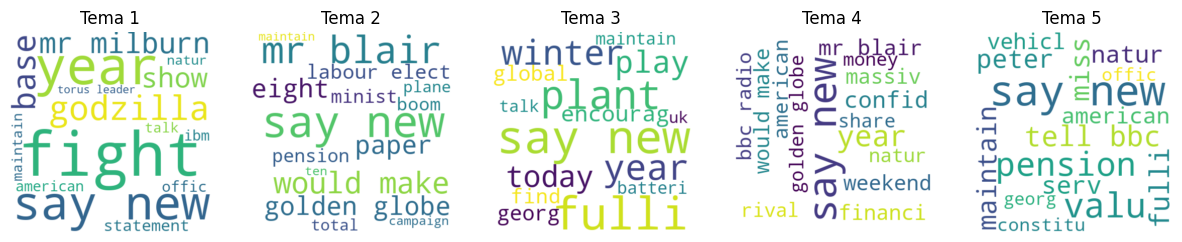



Graphics bow_ngram_1_maxfeature_2000




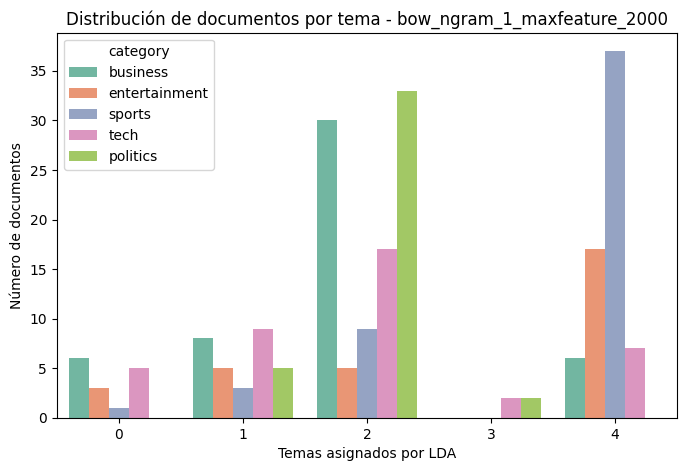

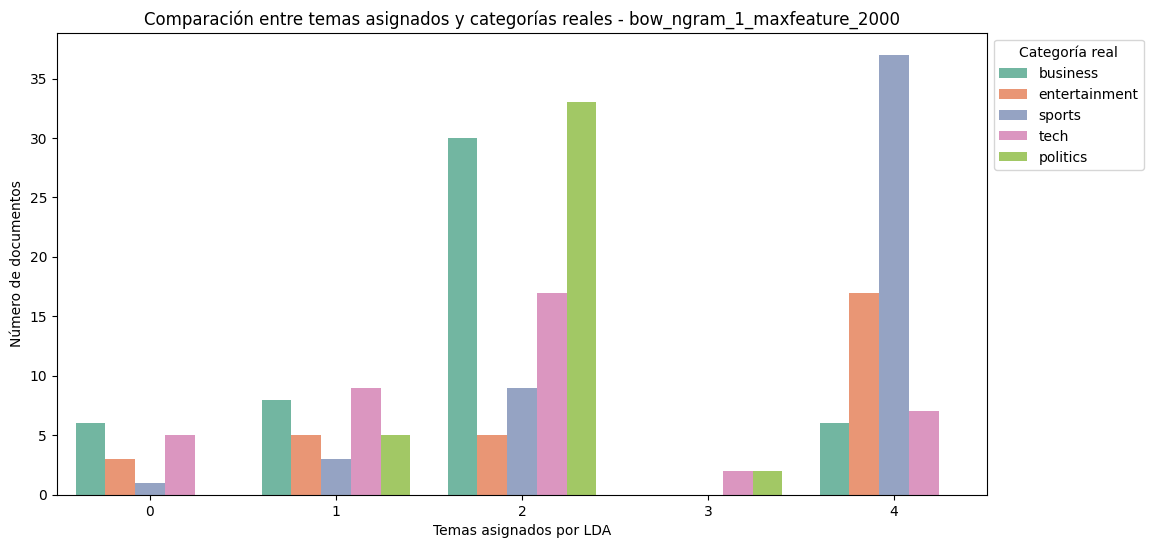

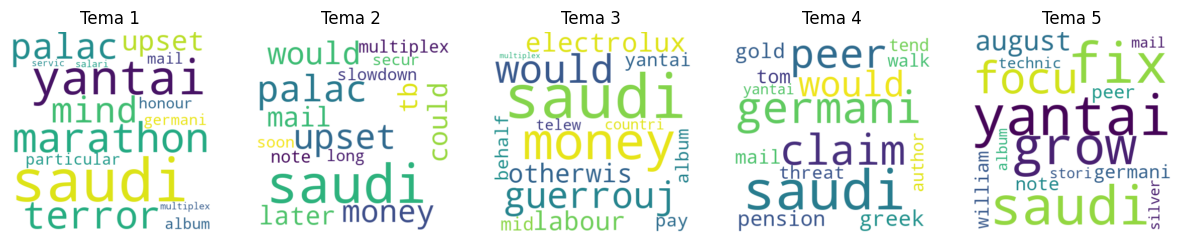



Graphics bow_ngram_2_maxfeature_2000




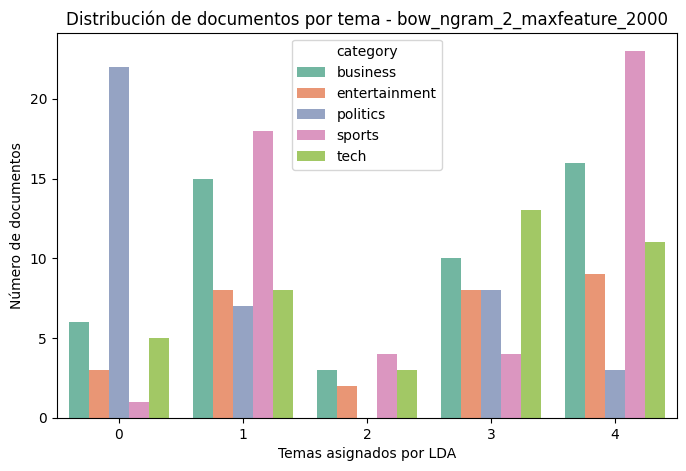

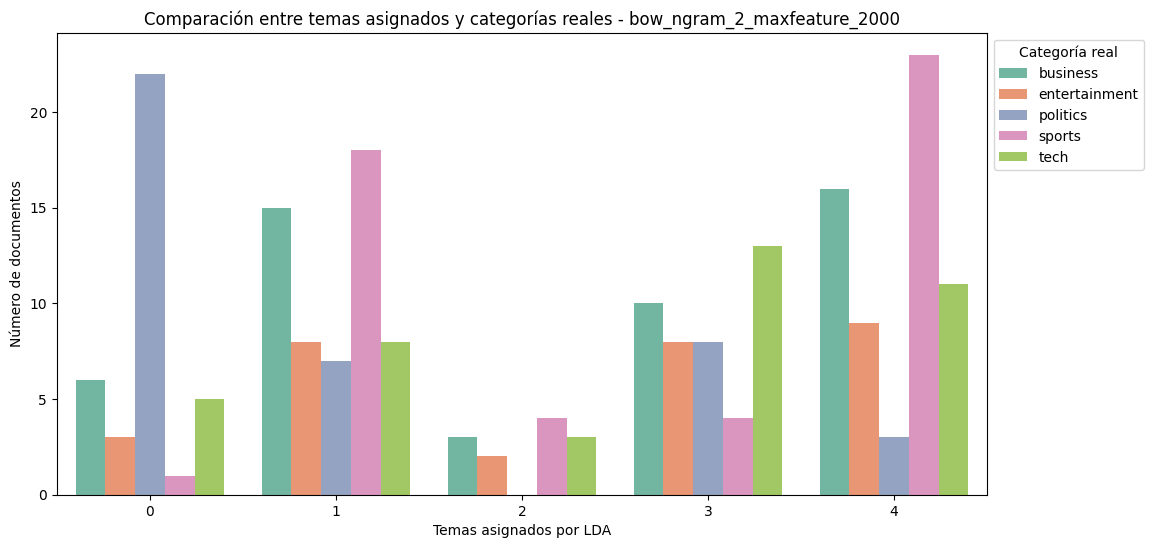

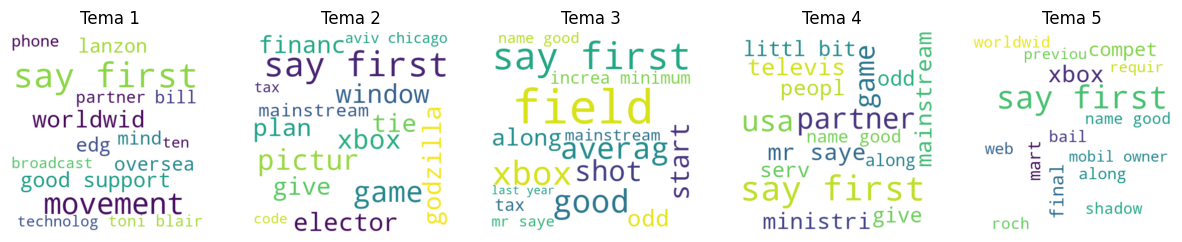



Graphics bow_ngram_3_maxfeature_2000




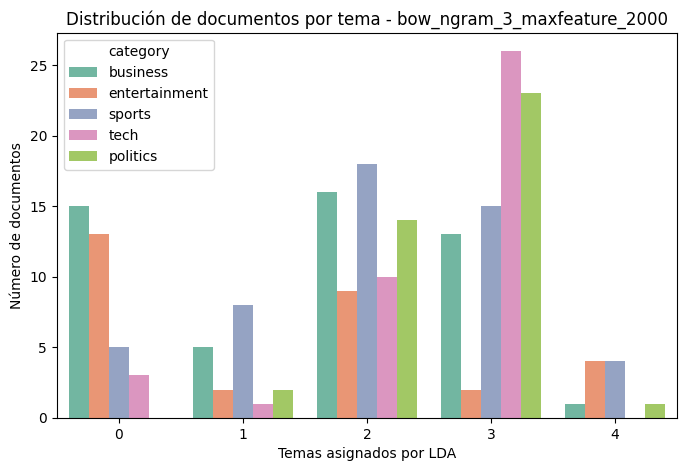

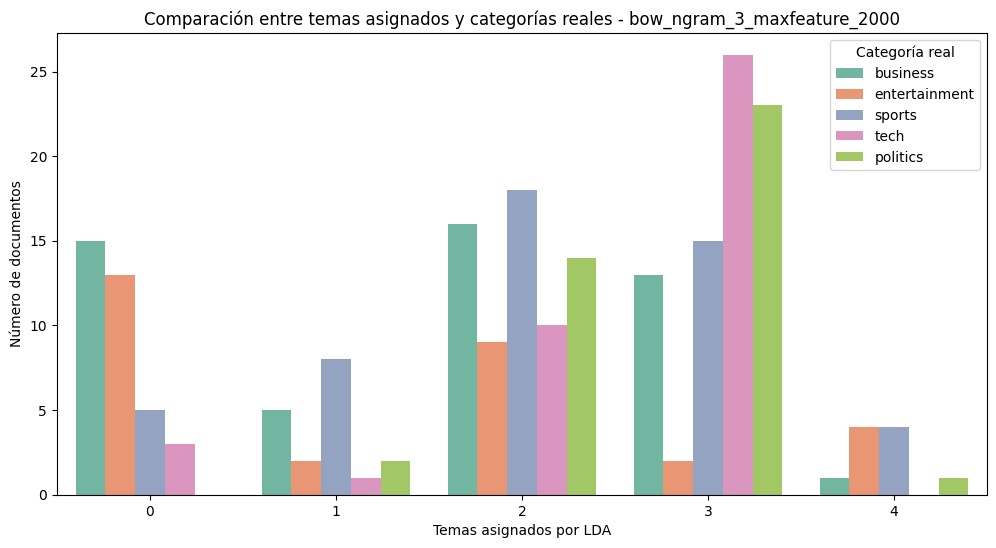

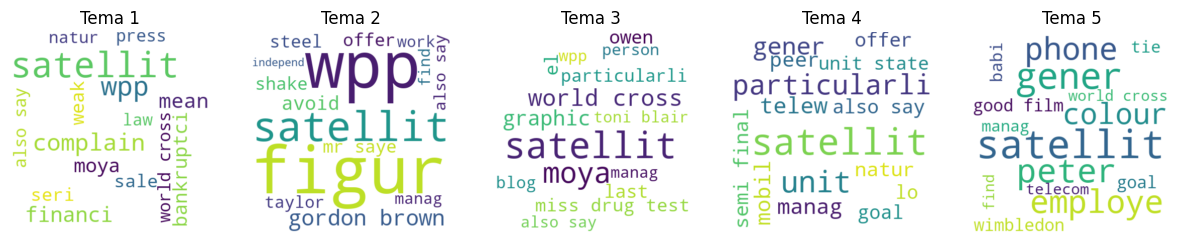



Graphics tfidf_ngram_1_maxfeature_500




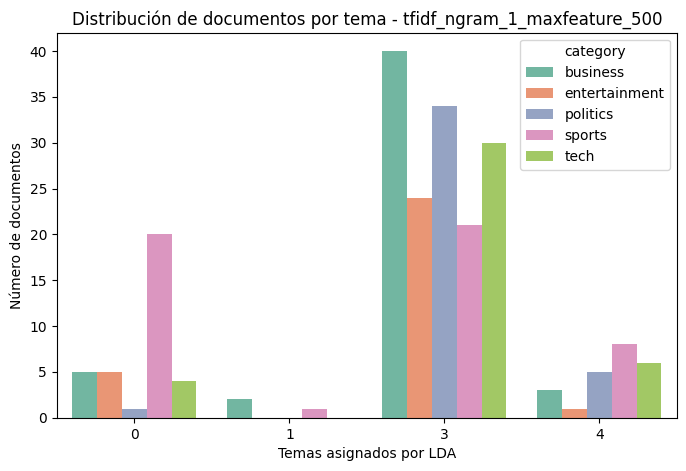

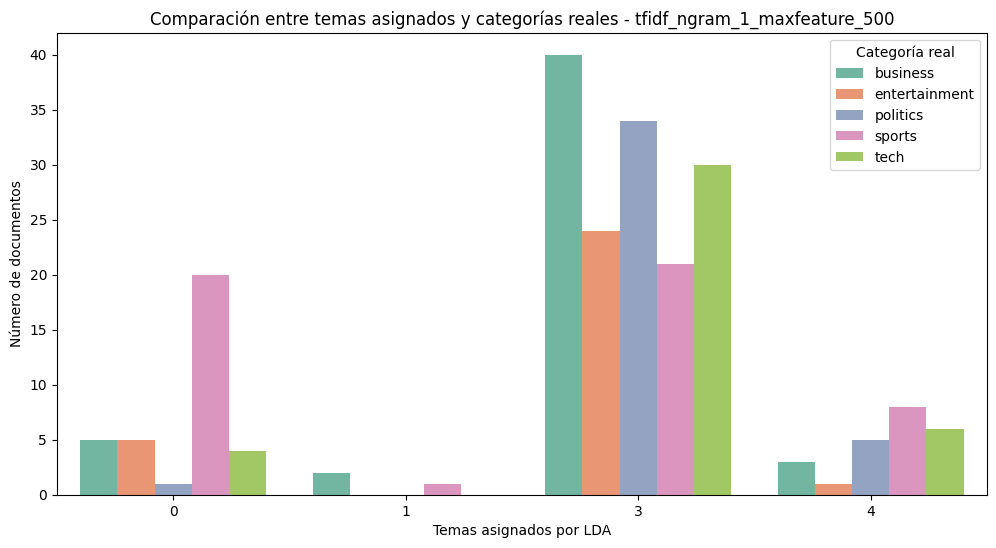

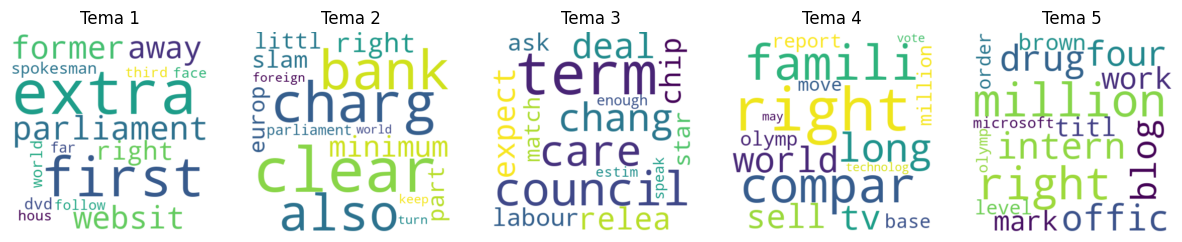



Graphics tfidf_ngram_2_maxfeature_500




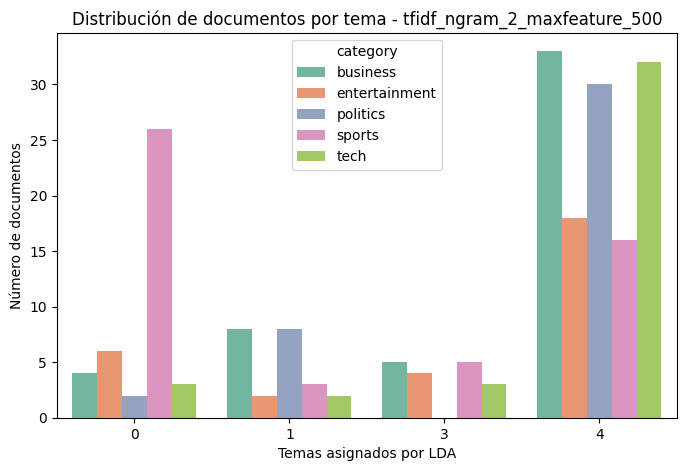

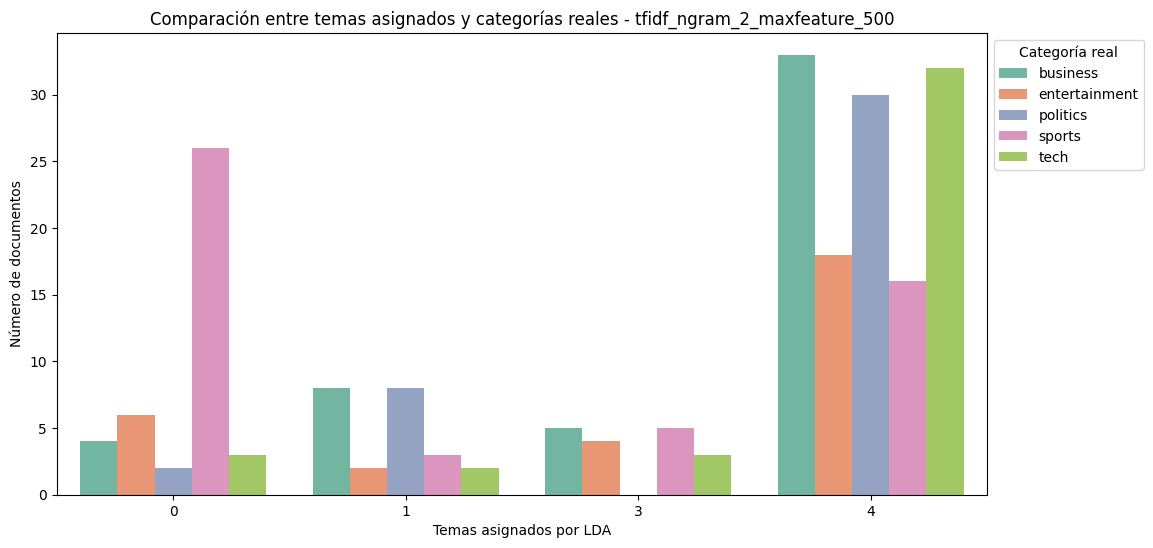

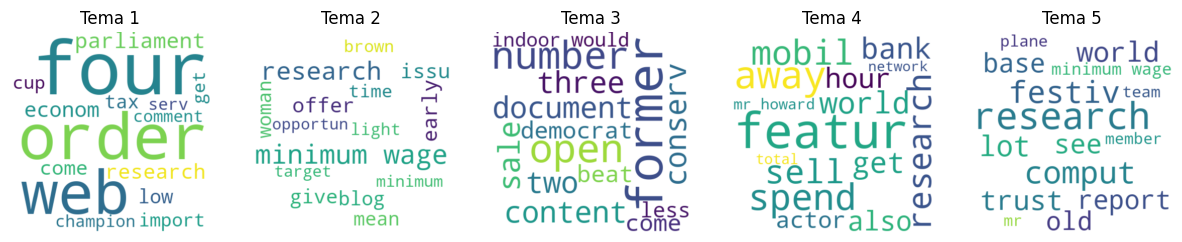



Graphics tfidf_ngram_3_maxfeature_500




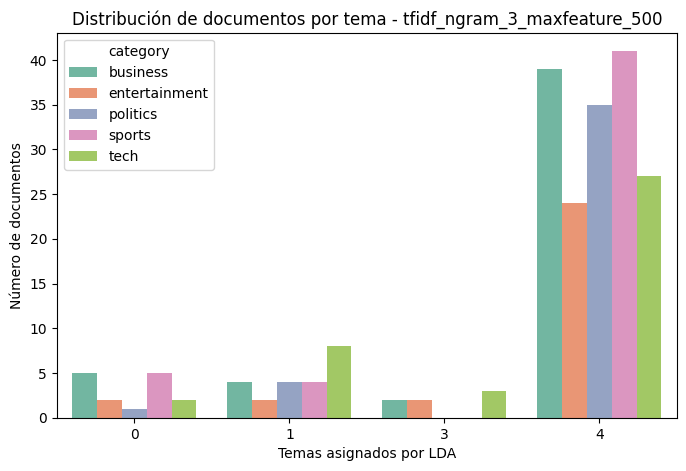

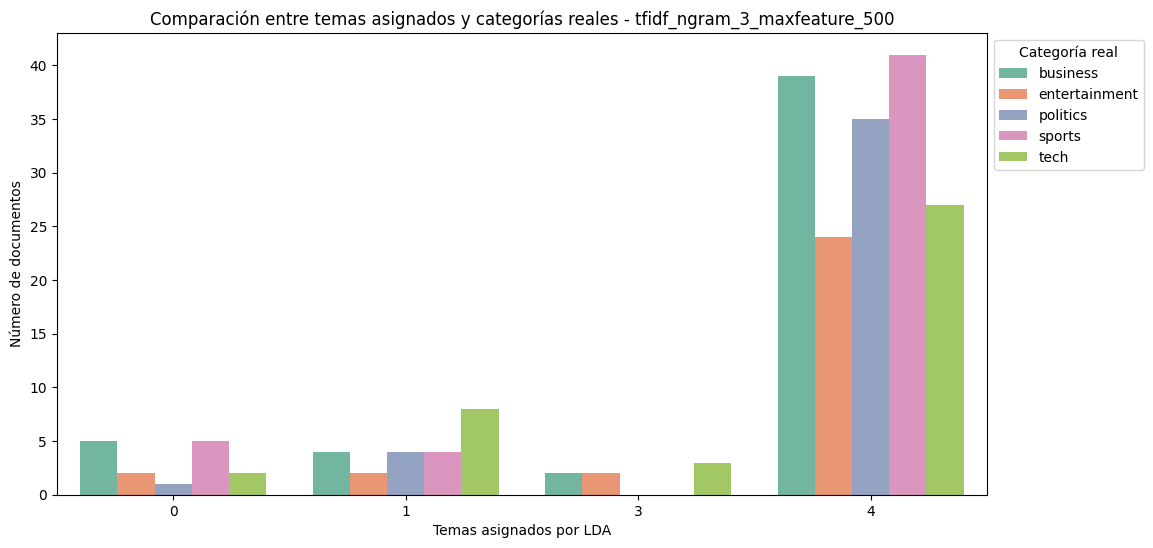

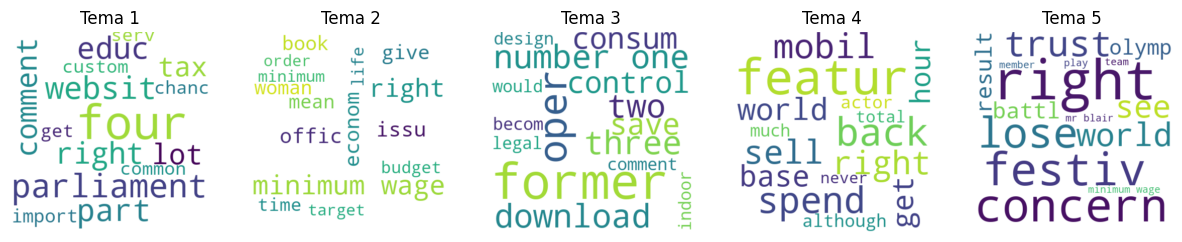



Graphics tfidf_ngram_1_maxfeature_1000




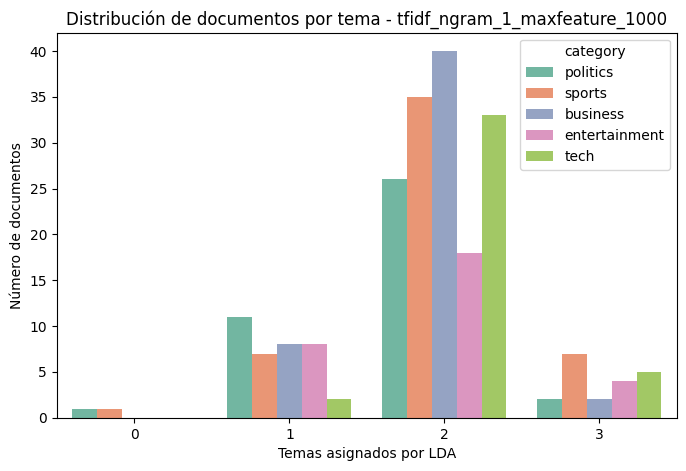

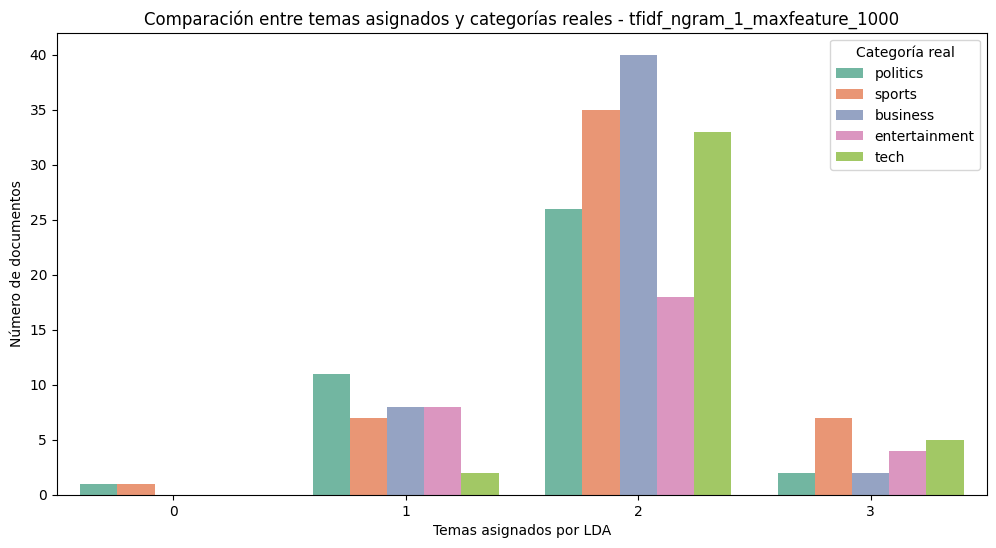

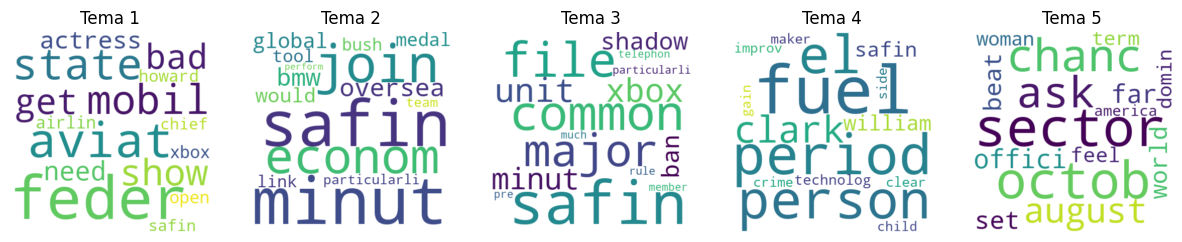



Graphics tfidf_ngram_2_maxfeature_1000




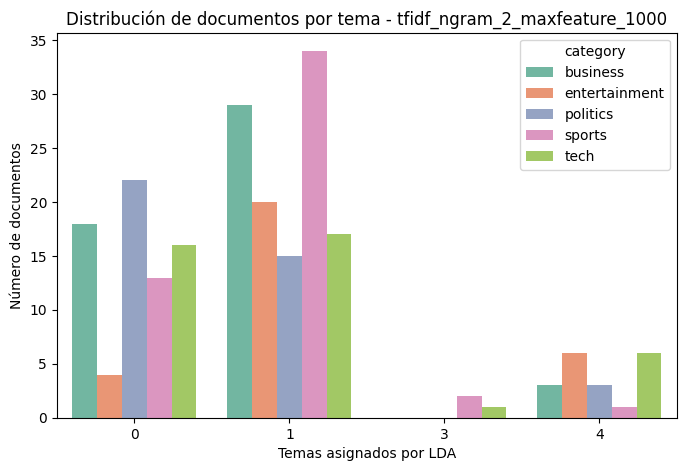

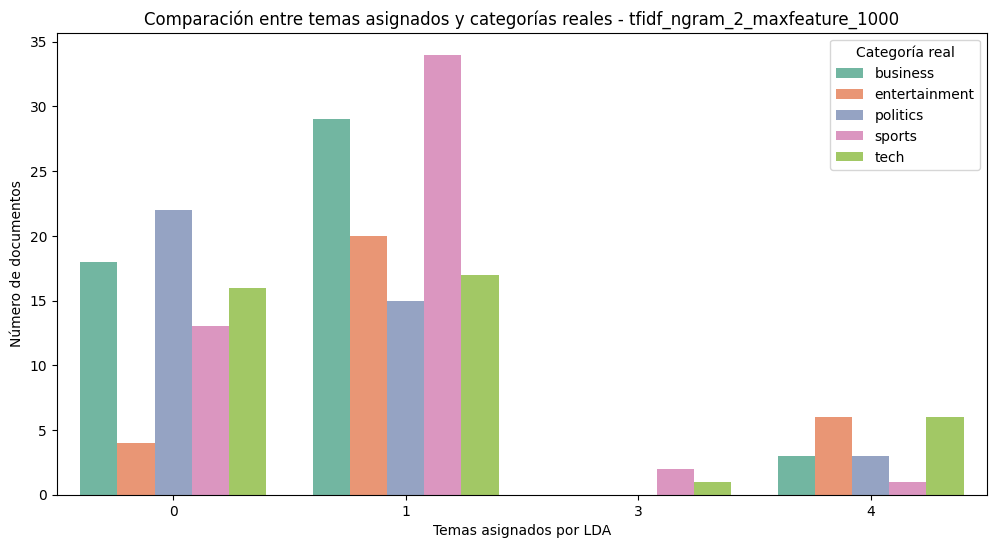

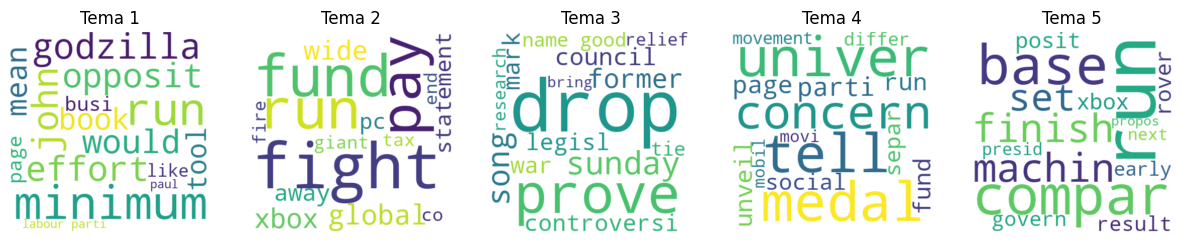



Graphics tfidf_ngram_3_maxfeature_1000




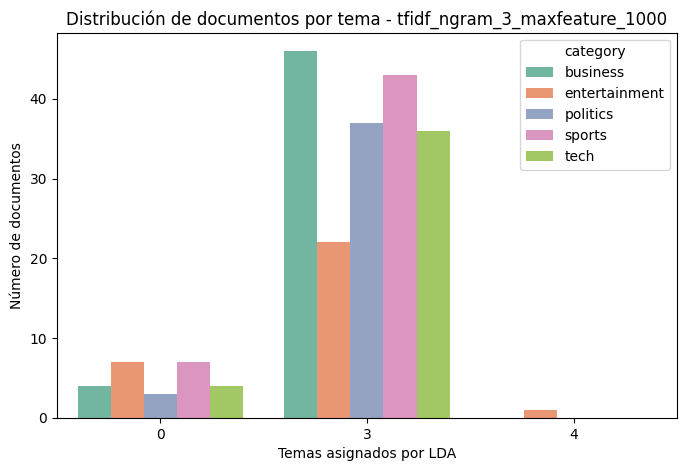

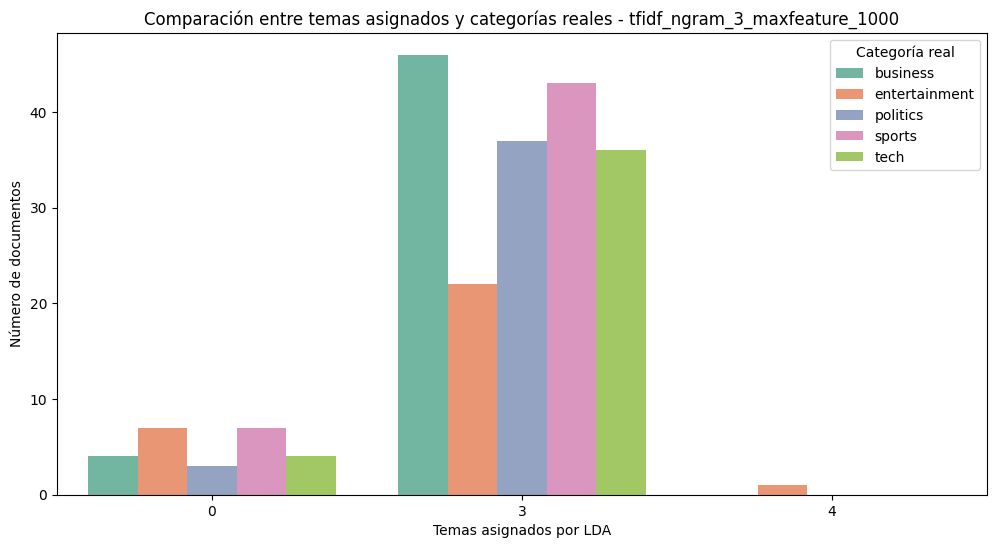

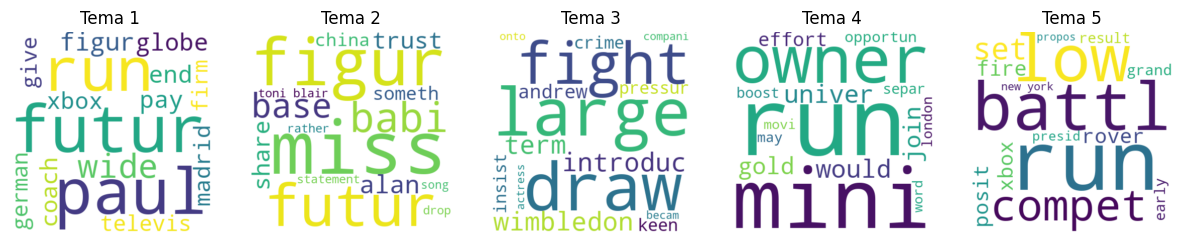



Graphics tfidf_ngram_1_maxfeature_1500




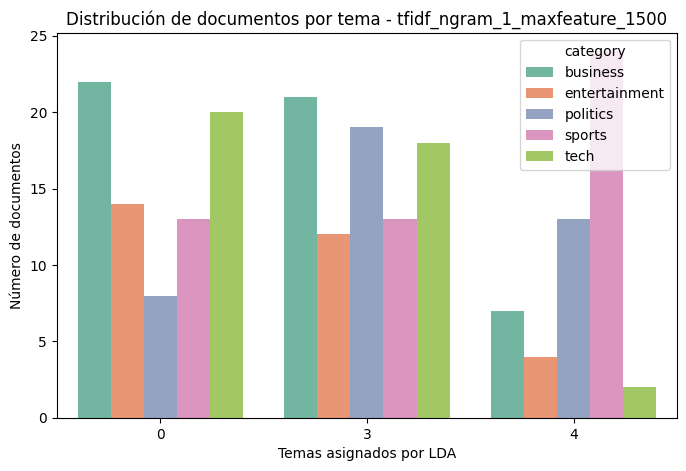

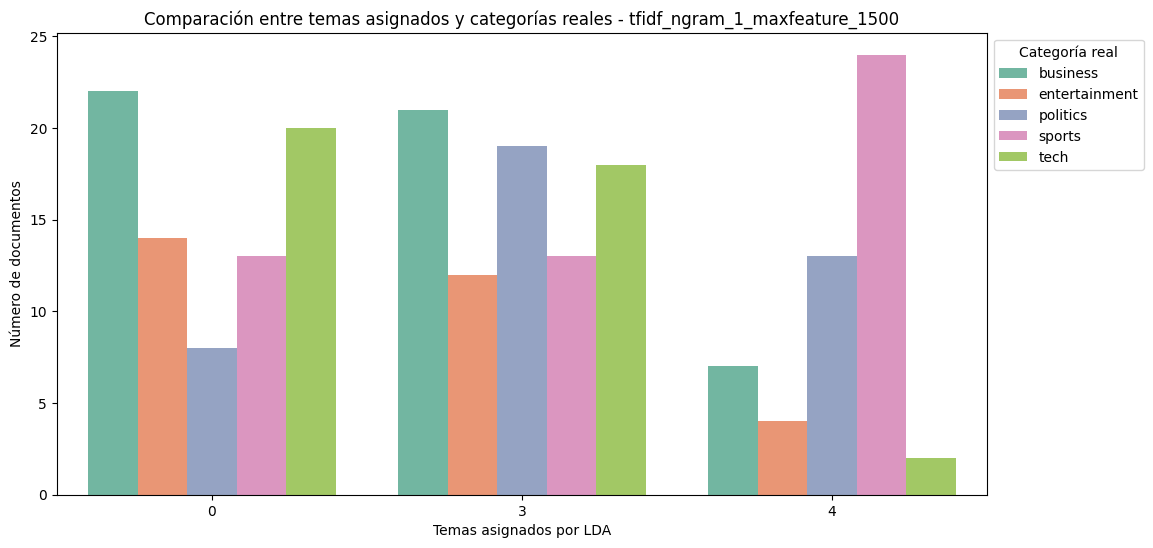

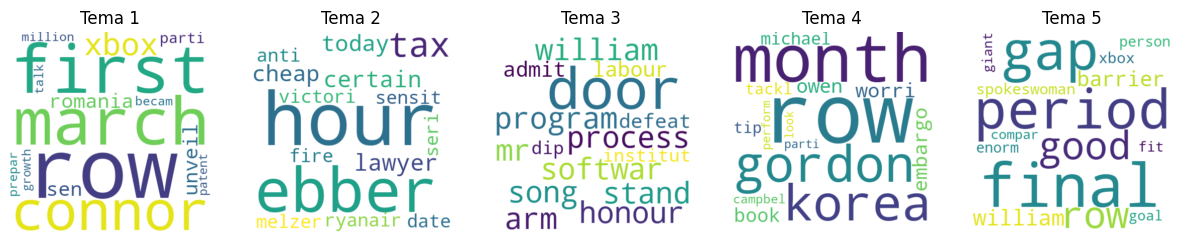



Graphics tfidf_ngram_2_maxfeature_1500




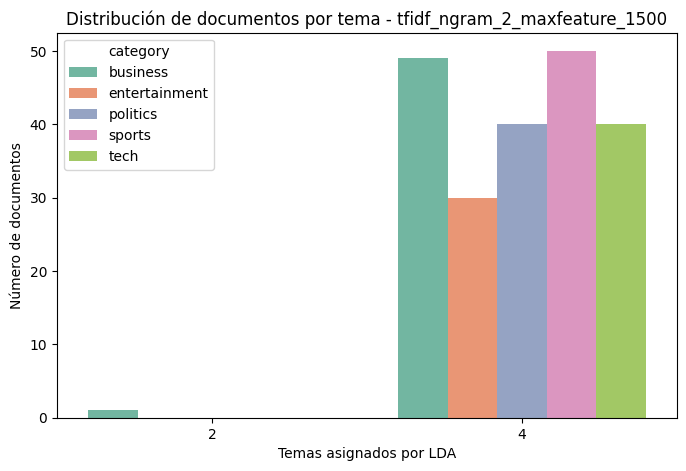

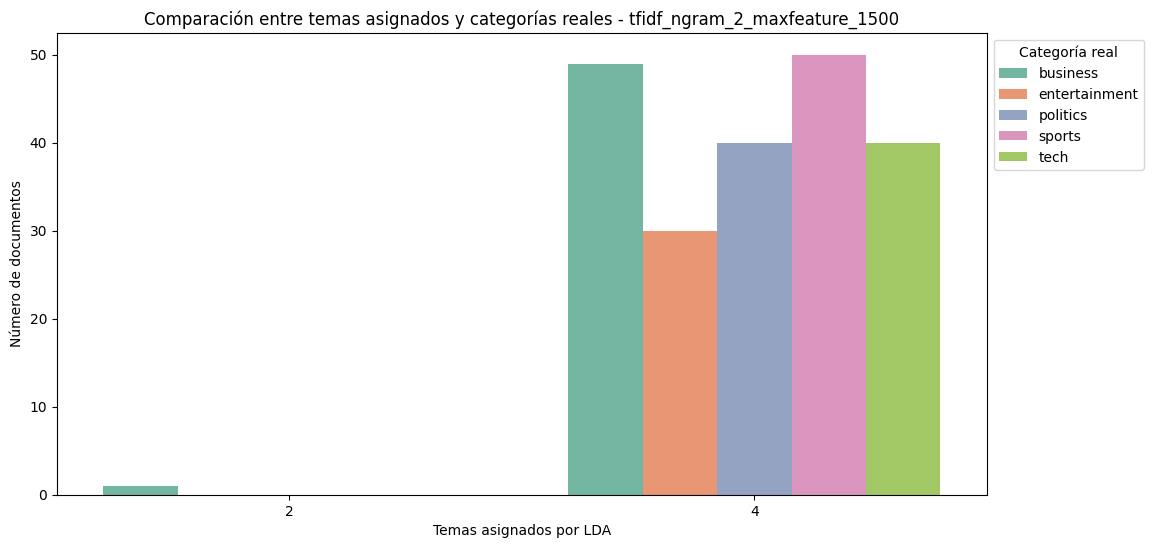

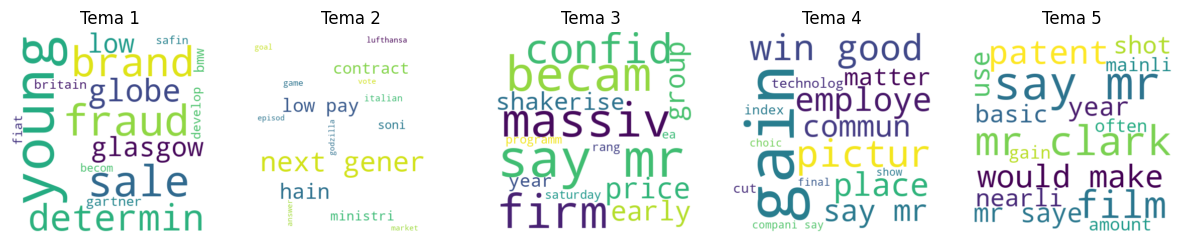



Graphics tfidf_ngram_3_maxfeature_1500




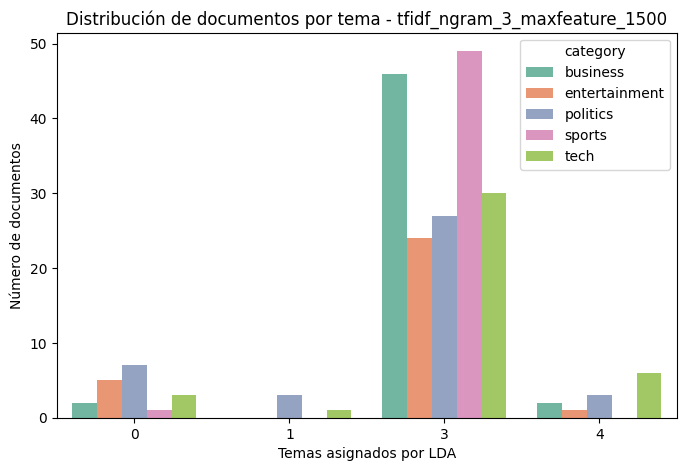

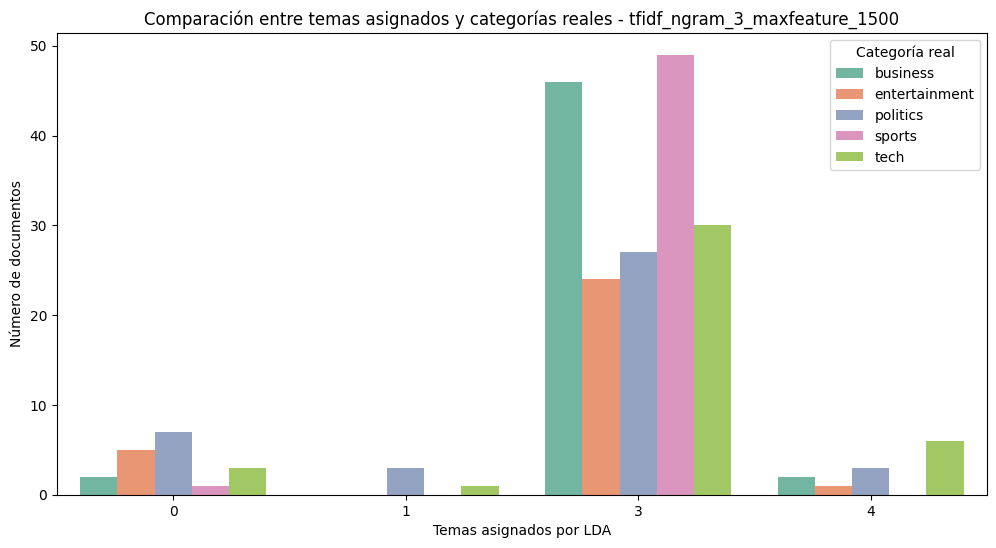

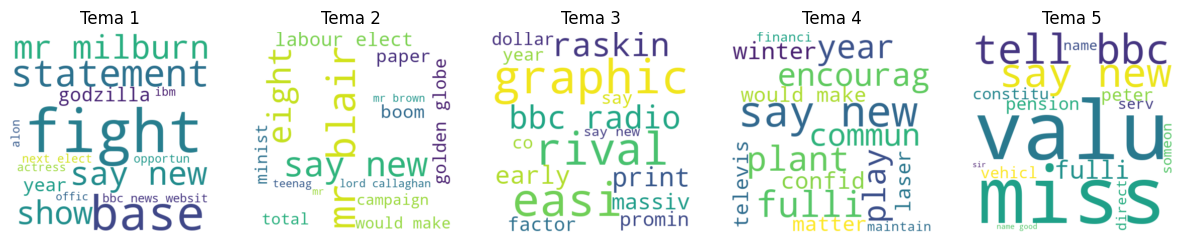



Graphics tfidf_ngram_1_maxfeature_2000




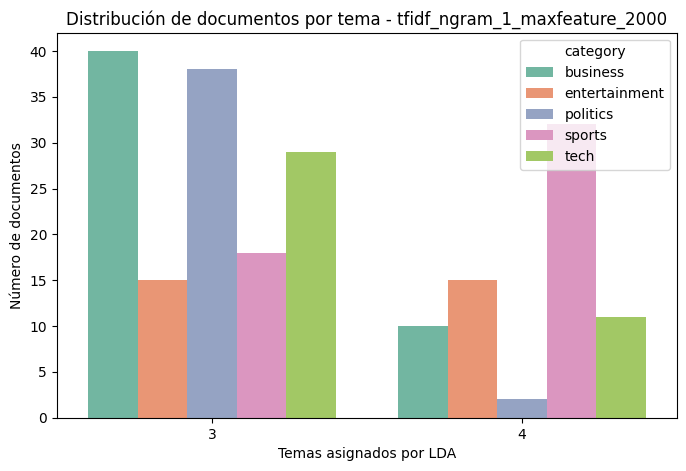

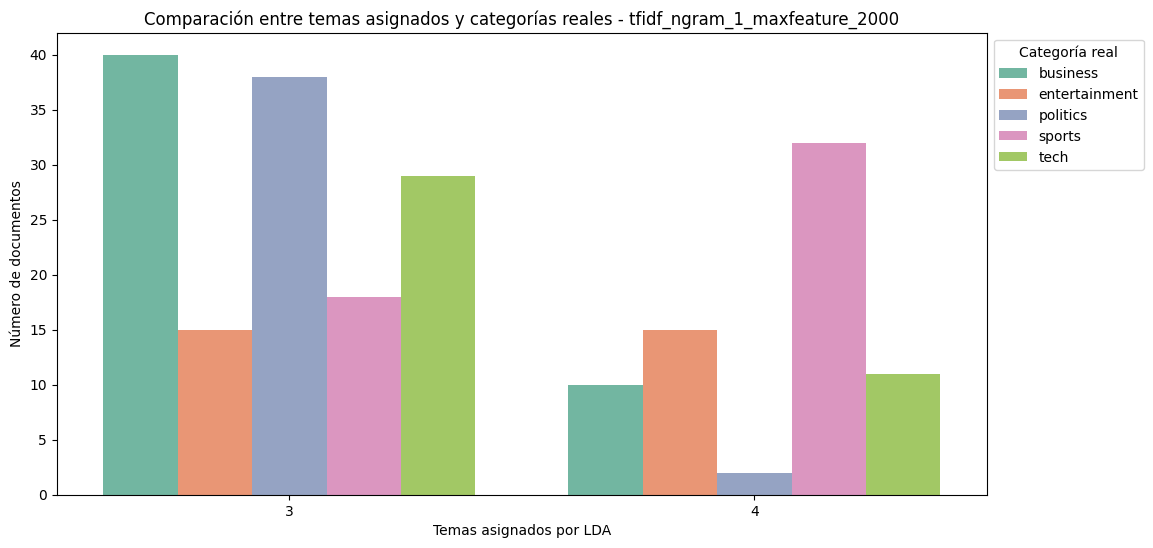

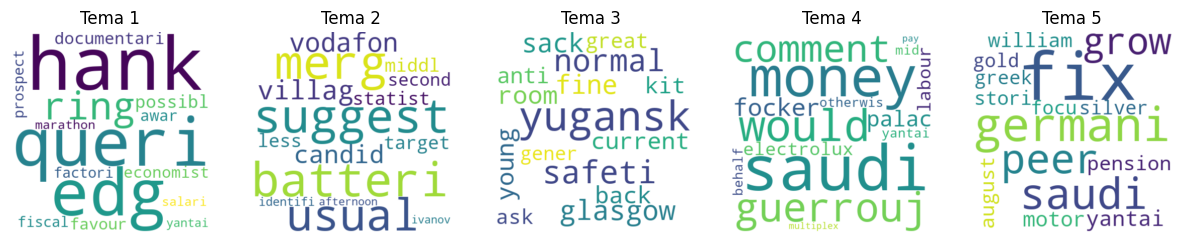



Graphics tfidf_ngram_2_maxfeature_2000




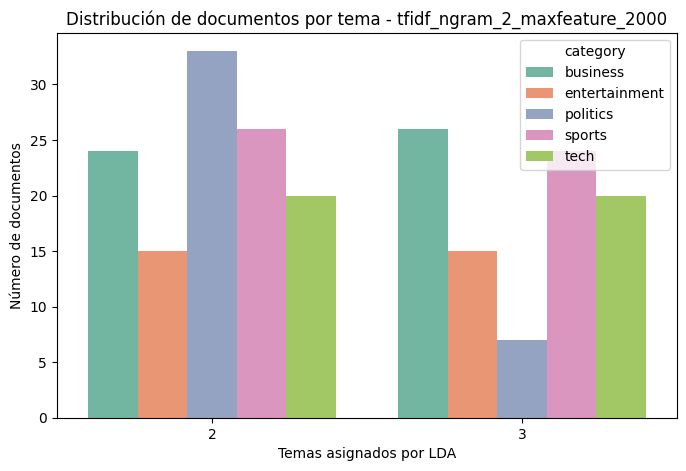

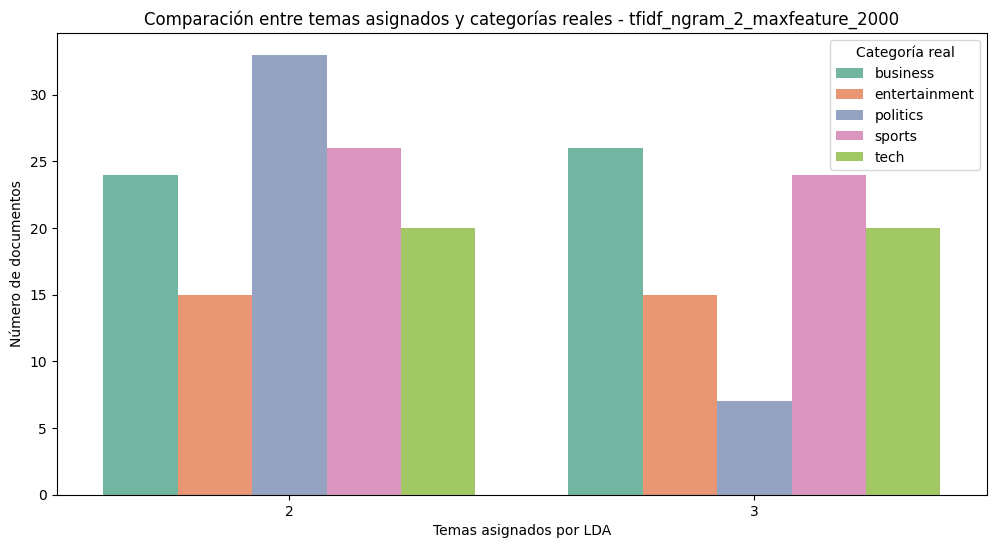

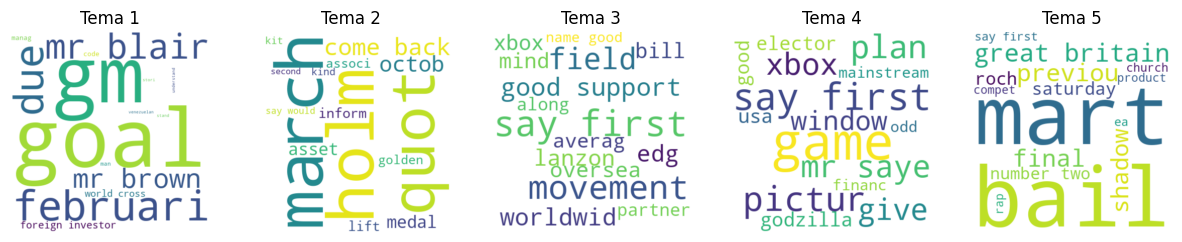



Graphics tfidf_ngram_3_maxfeature_2000




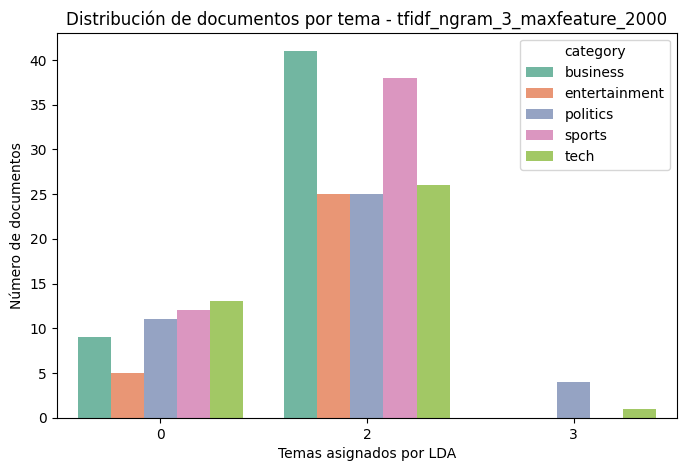

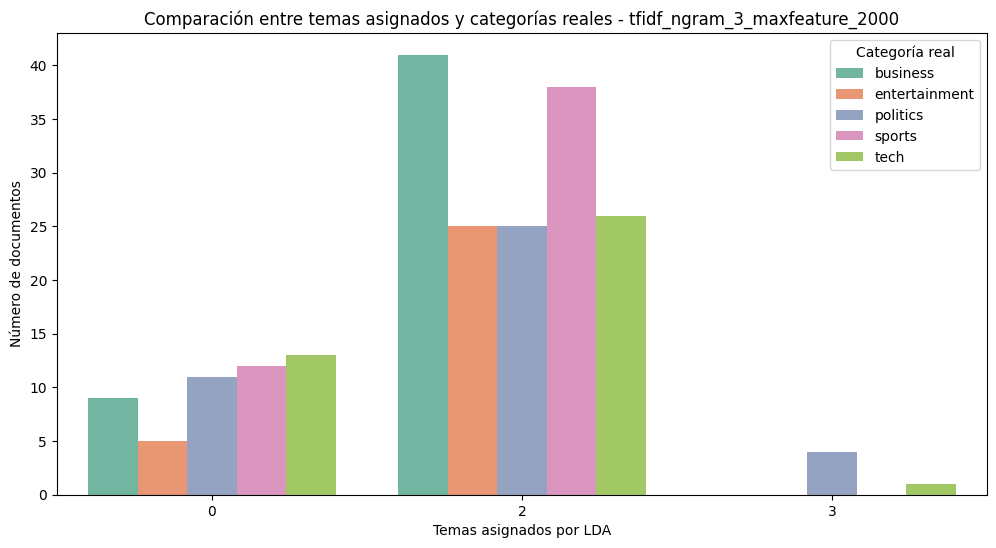

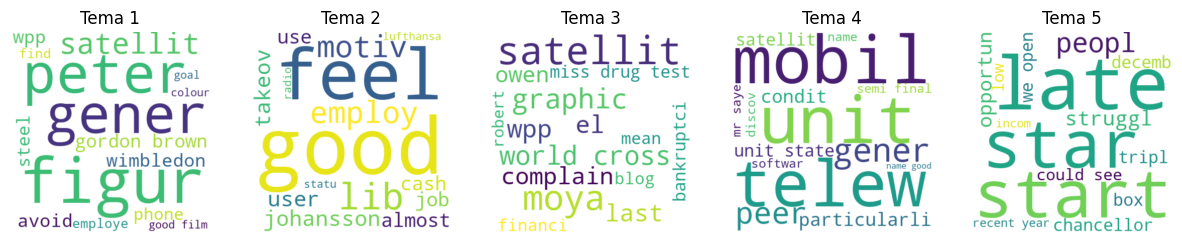

In [56]:
# Evaluación en conjunto de prueba (df_test)
df_test["processed_text"] = df_test["processed"].apply(lambda x: " ".join(x))  # Unimos tokens en texto

for rep in representations:
  for max_feature in max_features:
    for ngram_range in n_gram_ranges:
      key = f"{rep}_ngram_{ngram_range[1]}_maxfeature_{max_feature}"
      vectorizer, _ = represent_text(df_test, method=rep, ngram_range=ngram_range, max_features=max_feature)
      X_test = vectorizer.transform(df_test["processed_text"])  # Usamos el vectorizador entrenado
      doc_topic_distributions_test = models[key]["model"].transform(X_test)
      df_test["assigned_topic"] = np.argmax(doc_topic_distributions_test, axis=1)
      print(f'\n==================\n\nGraphics {key}\n\n==================\n')
      plot_topic_distribution(df_test, key)
      plot_category_vs_topic(df_test, key)

      # Promediar la distribución de tópicos para todo el conjunto de prueba
      feature_names = vectorizer.get_feature_names_out()
      topic_weights = np.mean(doc_topic_distributions_test, axis=0)

      plot_wordclouds(models[key]["model"], feature_names, num_topics=5)

In [57]:
import pickle

with open("models/lda_models.pkl", "wb") as f:
    pickle.dump(models, f)

# Almacenamiento de datos

In [58]:
df_train.to_csv('csv_files/results/training_dataset.csv')
df_test.to_csv('csv_files/results/testing_dataset.csv')